## CAPSTONE PROJECT: 
### NYT, Global Warming, iShares Global Clean Energy ETF 

_Course: GA Data Science (Part-Time)_ 

_Date: 04-20-2022_ 

_Name: Theresa (Tessa) Waters_


### Introduction

When I was brainstorming for my final General Assembly project I knew I wanted to challenge myself to implement new concepts as well as those I learned throughout the course. But first I needed an idea: 

The idea stemmed from my personal interests. My background is in biology - particularly ecology/climate science. The biggest takeaway I have from my experience in scientific research is the absolute necessity for a greener economy. To mitigate climate change, governments, businesses, and individuals need to boost investments in clean energy to drastically reduce carbon emissions. For this reason, I decided to look into clean energy ETFs for my project. 

ETFs (Exchange-traded fund) are "a collection of securities that can be bought and sold in shares on a stock exchange just like an individual stock" (TheStreet). Investing in ETFs focused on clean energy allows investors to flow money into the alternative energy sector at a low risk.

I decided to pull data from the top clean energy ETF: iShares Global Clean Energy ETF (NASDAQ:ICLN). This ETF "focuses on global companies that produce energy from solar, wind, and other renewable energy sources" (The Motley Fool). After learning about Time Series at GA, I was interested in exploring how the results of the fund may be influenced by exogenous factors such as media coverage on climate change/renewable energy. 

That's when I decided to turn to the New York Times. The NYT has an excellent article archive API that lists every article published per day since 1851. Using the NYT allowed me to explore topic modeling and eventually determine the best way to extract all the articles published that relate to climate change. 

Since the iShares Global Clean Energy ETF is only a little over a decade old, I decided to extract ETF and NYT data from the last 10 years. Using shares volume and article counts per day my first goal was to answer the question: 

Does a clean energy ETF's volume rise when there is more media coverage of issues surrounding climate change? 

My second goal was to then create a Time Series model that could predict ETF volume with climate change article number included as an imposed variable. 

Enjoy the journey of how I developed my model! 






### 1.0 Getting Set-Up

In [11]:
#Load dependencies

import os
import json
import time
import requests
import datetime
import dateutil
import pandas as pd
import matplotlib 
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#### 1.1 NYT API

Extracting 10 years of article data from NYT Archive API

In [16]:
#Specify the date range

end = datetime.date.today()
start = end - relativedelta(years=10)

print('End:', end)
print('Start:', start)

End: 2022-04-17
Start: 2012-04-17


In [18]:
#Create a list of years + month 

months_in_range = [x.split(' ') for x in pd.date_range(start, end, freq='MS').strftime("%Y %-m").tolist()]
months_in_range

[['2012', '5'],
 ['2012', '6'],
 ['2012', '7'],
 ['2012', '8'],
 ['2012', '9'],
 ['2012', '10'],
 ['2012', '11'],
 ['2012', '12'],
 ['2013', '1'],
 ['2013', '2'],
 ['2013', '3'],
 ['2013', '4'],
 ['2013', '5'],
 ['2013', '6'],
 ['2013', '7'],
 ['2013', '8'],
 ['2013', '9'],
 ['2013', '10'],
 ['2013', '11'],
 ['2013', '12'],
 ['2014', '1'],
 ['2014', '2'],
 ['2014', '3'],
 ['2014', '4'],
 ['2014', '5'],
 ['2014', '6'],
 ['2014', '7'],
 ['2014', '8'],
 ['2014', '9'],
 ['2014', '10'],
 ['2014', '11'],
 ['2014', '12'],
 ['2015', '1'],
 ['2015', '2'],
 ['2015', '3'],
 ['2015', '4'],
 ['2015', '5'],
 ['2015', '6'],
 ['2015', '7'],
 ['2015', '8'],
 ['2015', '9'],
 ['2015', '10'],
 ['2015', '11'],
 ['2015', '12'],
 ['2016', '1'],
 ['2016', '2'],
 ['2016', '3'],
 ['2016', '4'],
 ['2016', '5'],
 ['2016', '6'],
 ['2016', '7'],
 ['2016', '8'],
 ['2016', '9'],
 ['2016', '10'],
 ['2016', '11'],
 ['2016', '12'],
 ['2017', '1'],
 ['2017', '2'],
 ['2017', '3'],
 ['2017', '4'],
 ['2017', '5'],
 ['2017',

Now for collecting my data from the NYT: Brienna Herold, a data analyst, published her extremely helpful code on towardsdatascience.com: 

In [20]:
#Let's get some data! 

def send_request(date):
    ### Sends a request to the NYT Archive API for given date 
    base_url = 'https://api.nytimes.com/svc/archive/v1/'
    url = base_url + '/' + date[0] + '/' + date[1] + '.json?api-key=' + 'S2ttldj1DLlraerAxStAbXAWkiArpDJr'
    response = requests.get(url).json()
    time.sleep(6)
    return response

def is_valid(article, date):
    ### An article is only worth checking if it is in range, and has a headline 
    is_in_range = date > start and date < end
    has_headline = type(article['headline']) == dict and 'main' in article['headline'].keys()
    return is_in_range and has_headline


def parse_response(response):
    ### Parses and returns response as pandas data frame 
    data = {'headline': [],  
        'date': [], 
        'doc_type': [],
        'material_type': [],
        'section': [],
        'keywords': [],
        'abstract': [],
        'lead_paragraph': []}
    articles = response['response']['docs'] 
    for article in articles: # For each article, make sure it falls within our date range
        date = dateutil.parser.parse(article['pub_date']).date()
        if is_valid(article, date):
            data['date'].append(date)
            data['headline'].append(article['headline']['main']) 
            if 'section' in article:
                data['section'].append(article['section_name'])
            else:
                data['section'].append(None)
            data['doc_type'].append(article['document_type'])
            if 'type_of_material' in article: 
                data['material_type'].append(article['type_of_material'])
            else:
                data['material_type'].append(None)
            if 'abstract' in article:
                data['abstract'].append(article['abstract'])
            else: 
                data['abstract'].append(None)
            if 'lead_paragraph' in article:
                data['lead_paragraph'].append(article['lead_paragraph'])
            else:
                data['lead_paragraph'].append(None)
            keywords = [keyword['value'] for keyword in article['keywords'] if keyword['name'] == 'subject']
            data['keywords'].append(keywords)
    return pd.DataFrame(data) 


def get_data(dates):
    ### Sends and parses request/response to/from NYT Archive API for given dates 
    total = 0
    print('Date range: ' + str(dates[0]) + ' to ' + str(dates[-1]))
    if not os.path.exists('headlines'):
        os.mkdir('headlines')
    for date in dates:
        response = send_request(date)
        df = parse_response(response)
        total += len(df)
        df.to_csv('headlines/' + date[0] + '-' + date[1] + '.csv', index=False)
        print('Saving headlines/' + date[0] + '-' + date[1] + '.csv...')
    print('Number of articles collected: ' + str(total))



In [21]:
get_data(months_in_range)

Date range: ['2012', '5'] to ['2022', '4']
Saving headlines/2012-5.csv...
Saving headlines/2012-6.csv...
Saving headlines/2012-7.csv...
Saving headlines/2012-8.csv...
Saving headlines/2012-9.csv...
Saving headlines/2012-10.csv...
Saving headlines/2012-11.csv...
Saving headlines/2012-12.csv...
Saving headlines/2013-1.csv...
Saving headlines/2013-2.csv...
Saving headlines/2013-3.csv...
Saving headlines/2013-4.csv...
Saving headlines/2013-5.csv...
Saving headlines/2013-6.csv...
Saving headlines/2013-7.csv...
Saving headlines/2013-8.csv...
Saving headlines/2013-9.csv...
Saving headlines/2013-10.csv...
Saving headlines/2013-11.csv...
Saving headlines/2013-12.csv...
Saving headlines/2014-1.csv...
Saving headlines/2014-2.csv...
Saving headlines/2014-3.csv...
Saving headlines/2014-4.csv...
Saving headlines/2014-5.csv...
Saving headlines/2014-6.csv...
Saving headlines/2014-7.csv...
Saving headlines/2014-8.csv...
Saving headlines/2014-9.csv...
Saving headlines/2014-10.csv...
Saving headlines/201

In [2]:
# Making a data frame 

import glob
import os

files = os.path.join('headlines/20*.csv')
files = glob.glob(files)

# joining files with concat and read_csv
df = pd.concat(map(pd.read_csv, files), ignore_index=True)
df.head(10)

,headline,date,doc_type,material_type,section,keywords,abstract,lead_paragraph
0,Trump’s Book Club: A President Who Doesn’t Rea...,2018-12-01,article,News,NaN,"['Books and Literature', 'United States Politi...","President Trump, who is not a reader, has used...","WASHINGTON — President Trump, a leader who is ..."
1,Kareem Hunt Is Cut by the Chiefs After a Video...,2018-12-01,article,News,NaN,"['Football', 'Domestic Violence']","Hunt, a star running back, was also suspended ...",The Kansas City Chiefs cut their star running ...
2,Agency Pulls Back on Its Warning Against Talk ...,2018-12-01,article,News,NaN,['Hatch Act (1939)'],Casual conversations about impeachment and inv...,"WASHINGTON — An independent government agency,..."
3,A China Hawk Gains Prominence as Trump Confron...,2018-12-01,article,News,NaN,"['United States International Relations', 'Uni...","Michael Pillsbury, the president’s top outside...",WASHINGTON — Michael Pillsbury had just finish...
4,Wilmer Flores Is a Met No More,2018-12-01,article,News,NaN,['Baseball'],"A fan favorite, Flores did not receive a contr...","The Mets parted ways with a fan favorite, Wilm..."
5,Will Trump Speak Up Against China’s Oppression?,2018-12-01,article,Editorial,NaN,"['United States International Relations', 'Hum...","In Argentina, President Trump has a chance to ...",As President Trump prepares to meet his Chines...
6,ISIS Official Known for Caging Foes Is Capture...,2018-12-01,article,News,NaN,"['Terrorism', 'Espionage and Intelligence Serv...",The captured operative was a midlevel official...,BAGHDAD — The Iraqi authorities released a vid...
7,Canada Faces a New Challenge as a Century of A...,2018-12-01,article,News,NaN,"['Layoffs and Job Reductions', 'Shutdowns (Ins...",Both Prime Minister Justin Trudeau and Premier...,This week wasn’t the first time I found myself...
8,High Stakes for House Freshmen: The Office Lot...,2018-12-01,article,News,NaN,"['Building Service Employees', 'Lotteries']",Forget coveted committee assignments and leade...,WASHINGTON — Colin Allred of Texas brought his...
9,Mets Appear Near a Deal for Robinson Cano and ...,2018-12-01,article,News,NaN,"['Baseball', 'Trades (Sports)']",The trade would require the Mets to give the S...,In explaining the Mets’ hiring of Brodie Van W...


#### 1.2 NYT: Exploratory Data Analysis and Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687270 entries, 0 to 687269
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   headline        687241 non-null  object 
 1   date            687270 non-null  object 
 2   doc_type        687270 non-null  object 
 3   material_type   679669 non-null  object 
 4   section         0 non-null       float64
 5   keywords        687270 non-null  object 
 6   abstract        686412 non-null  object 
 7   lead_paragraph  681347 non-null  object 
dtypes: float64(1), object(7)
memory usage: 41.9+ MB


In [4]:
material_type_vc = df['material_type'].value_counts()
material_type_vc

News                   481555
Review                  36462
Op-Ed                   32246
Slideshow               21421
Video                   20901
Interactive Feature     17370
Letter                  14530
Obituary (Obit)         11560
briefing                 9928
Editorial                8460
Schedule                 5861
Question                 3632
Brief                    3531
Quote                    3138
List                     3036
News Analysis            1968
Correction               1941
Interview                 542
Biography                 304
Text                      287
recipe                    284
Special Report            142
Web Log                   120
An Appraisal              118
Newsletter                 80
An Analysis                56
Summary                    46
Series                     42
Caption                    35
Economic Analysis          23
First Chapter              19
Interactive Graphic        11
Military Analysis           8
Audio Podc

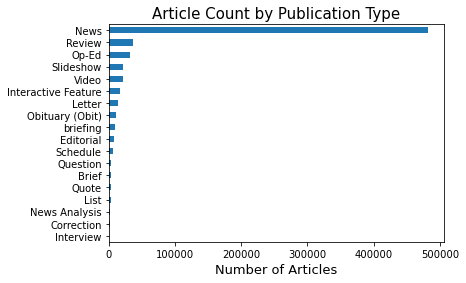

In [13]:
df['material_type'].value_counts(ascending=True).loc[df['material_type'].value_counts() > 500].plot(kind='barh')

plt.title('Article Count by Publication Type', fontsize=15)
plt.xlabel('Number of Articles', fontsize=13)
plt.show()



Clearly news is the most utilized material type. This will probably be where I want to look for articles surrounding Global Warming.

In [14]:
#Create a new dataframe with only News articles 

df_news = df[df['material_type'] == 'News']
df_news.head(5)

,headline,date,doc_type,material_type,section,keywords,abstract,lead_paragraph
0,Trump’s Book Club: A President Who Doesn’t Rea...,2018-12-01,article,News,NaN,"['Books and Literature', 'United States Politi...","President Trump, who is not a reader, has used...","WASHINGTON — President Trump, a leader who is ..."
1,Kareem Hunt Is Cut by the Chiefs After a Video...,2018-12-01,article,News,NaN,"['Football', 'Domestic Violence']","Hunt, a star running back, was also suspended ...",The Kansas City Chiefs cut their star running ...
2,Agency Pulls Back on Its Warning Against Talk ...,2018-12-01,article,News,NaN,['Hatch Act (1939)'],Casual conversations about impeachment and inv...,"WASHINGTON — An independent government agency,..."
3,A China Hawk Gains Prominence as Trump Confron...,2018-12-01,article,News,NaN,"['United States International Relations', 'Uni...","Michael Pillsbury, the president’s top outside...",WASHINGTON — Michael Pillsbury had just finish...
4,Wilmer Flores Is a Met No More,2018-12-01,article,News,NaN,['Baseball'],"A fan favorite, Flores did not receive a contr...","The Mets parted ways with a fan favorite, Wilm..."


In [15]:
#Remove the section data since it is all null 

df_news.drop('section', axis=1, inplace=True)
df_news.head(2)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,headline,date,doc_type,material_type,keywords,abstract,lead_paragraph
0,Trump’s Book Club: A President Who Doesn’t Rea...,2018-12-01,article,News,"['Books and Literature', 'United States Politi...","President Trump, who is not a reader, has used...","WASHINGTON — President Trump, a leader who is ..."
1,Kareem Hunt Is Cut by the Chiefs After a Video...,2018-12-01,article,News,"['Football', 'Domestic Violence']","Hunt, a star running back, was also suspended ...",The Kansas City Chiefs cut their star running ...


In [67]:
# Look for more nulls - need text data 

df_news.info() 

# Nulls in the headline and abstract - as long as there is at least one of these 
# there should be no need to drop 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 481555 entries, 0 to 687268
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   headline        481548 non-null  object
 1   date            481555 non-null  object
 2   doc_type        481555 non-null  object
 3   material_type   481555 non-null  object
 4   keywords        481555 non-null  object
 5   abstract        481462 non-null  object
 6   lead_paragraph  476846 non-null  object
dtypes: object(7)
memory usage: 29.4+ MB


In [16]:
no_text_info = df_news[(df_news.abstract.isnull()) & (df_news.headline.isnull())]

no_text_info

# Can definitely drop these 


,headline,date,doc_type,material_type,keywords,abstract,lead_paragraph
287977,NaN,2021-03-29,audiocontainer,News,[],NaN,NaN
309026,NaN,2021-02-01,audiocontainer,News,[],NaN,NaN


In [17]:
df_news.drop(index = [287977] , axis=0, inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [18]:
df_news.drop(index = [309026] , axis=0, inplace=True)

In [19]:
# the percentage of missing data in each column - not too bad

df_news.isnull().sum() / len(df)

headline          0.000007
date              0.000000
doc_type          0.000000
material_type     0.000000
keywords          0.000000
abstract          0.000132
lead_paragraph    0.006849
dtype: float64

In [80]:
# Now checking for duplicates 

df_news.duplicated().value_counts()

False    481497
True         56
dtype: int64

In [81]:
# Does not actually look like real duplicates - some headlines are the same 
# but the rest of the text is different - no need to drop


df_news[df_news.duplicated()]

,headline,date,doc_type,material_type,keywords,abstract,lead_paragraph
25069,"News Quiz | September 3, 2013",2013-09-03,article,News,[],See what you know about the news of the day.,See what you know about the news below. To pre...
41546,What We’re Reading,2014-11-11,article,News,"['Banking and Financial Institutions', 'Comput...",Get recommendations from New York Times report...,Get recommendations from New York Times report...
44890,What We’re Reading,2014-11-25,article,News,"['Dairy Products', 'Mars (Planet)', 'Women and...",Get recommendations from New York Times report...,Get recommendations from New York Times report...
77735,Modern Picnic Wares for Photo-Worthy Alfresco ...,2013-08-06,article,News,[],These artisanal products will upgrade late-sum...,"Too often, picnic wares are an afterthought — ..."
86597,Trump in North Carolina: ‘All you hear is Covi...,2020-10-22,article,News,[],President Trump complained about the news medi...,President Trump complained about the news medi...
112512,What Happens When Flowers Have Too Much Power?,2020-02-07,article,News,['Books and Literature'],An artist illustrates her fascination with a f...,NaN
276691,A ‘bunch of kids’ ran a major vaccination site...,2021-01-29,article,News,['internal-essential'],With pressure mounting to get Covid-19 vaccine...,With pressure mounting to get Covid-19 vaccine...
417206,Homes for Sale in New York and New Jersey,2016-02-12,article,News,['Real Estate and Housing (Residential)'],This week’s homes include a six-bedroom in Col...,Click on the slide show to see this week’s fea...
426111,"One Kudo, Two Kudos?",2012-06-05,article,News,[],In noting a recent rash of “bona fides” in our...,"Notes from the newsroom on grammar, usage and ..."
426789,‘Frankenstein’ Comes Alive in the App Store,2012-06-07,article,News,[],A new interactive take on Mary Shelley’s “Fran...,An iPad app by Inkle Studios and Profile Books...


Before attempting to build topic models - how good of a job does NYT do with its keywords section?

In [20]:
def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

df_news['keywords_code'] = df_news['keywords'].apply(eval)

to_1D(df_news['keywords_code'])



/var/folders/2w/wbx4r95918vggzcgwttq04gh0000gn/T/ipykernel_1647/1007584266.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news['keywords_code'] = df_news['keywords'].apply(eval)


0                           Books and Literature
1          United States Politics and Government
2                 Presidents and Presidency (US)
3                                       Football
4                              Domestic Violence
                           ...                  
1255831           Economic Conditions and Trends
1255832                                 Gambling
1255833                                  Casinos
1255834                     Travel and Vacations
1255835                      Bars and Nightclubs
Length: 1255836, dtype: object

In [21]:
# Don't see anything related to climate change in the top 25

to_1D(df_news['keywords_code']).value_counts().head(25)

United States Politics and Government     29747
Coronavirus (2019-nCoV)                   17209
Politics and Government                   12589
Television                                11970
Weddings and Engagements                  11845
Movies                                    11332
Art                                       10888
Books and Literature                      10799
Real Estate and Housing (Residential)     10623
Baseball                                  10120
Presidential Election of 2016             10079
Fashion and Apparel                        9726
United States International Relations      9280
Computers and the Internet                 9222
Travel and Vacations                       8984
Music                                      8560
Women and Girls                            8032
Football                                   7317
Theater                                    7258
Blacks                                     7019
Black People                            

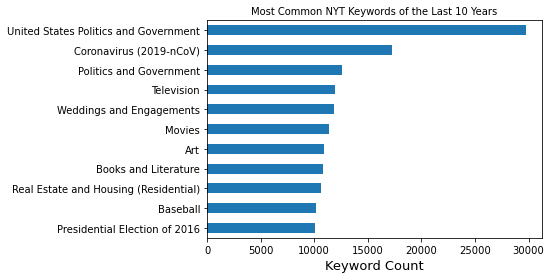

In [22]:
to_1D(df_news['keywords_code']).value_counts(ascending=True).loc[to_1D(df_news['keywords_code']).value_counts() > 10_000].plot(kind='barh')

plt.title('Most Common NYT Keywords of the Last 10 Years', fontsize=10)
plt.xlabel('Keyword Count', fontsize=13)
plt.show()

In [23]:
# NYT uses 'Global Warming' NOT 'Climate Change' as keyword

filter_object = filter(lambda a: 'Global Warming' in a, df_news['keywords'])
print(list(filter_object))

["['ALGAE', 'Global Warming', 'News and News Media', 'Dolphins and Porpoises', 'Water Pollution']", "['Ice', 'Animal Behavior', 'Seals (Animals) and Sealing', 'Polar Bears', 'Oil (Petroleum) and Gasoline', 'Wildlife Sanctuaries and Nature Reserves', 'Global Warming']", "['United States Politics and Government', 'Oil (Petroleum) and Gasoline', 'Native Americans', 'Federal Lands', 'Animal Migration', 'Polar Bears', 'Wildlife Sanctuaries and Nature Reserves', 'Reserves (Natural Resources)', 'Global Warming', 'Environment', 'Caribou']", "['Global Warming']", "['Global Warming', 'Environment', 'Greenhouse Gas Emissions', 'Carbon Dioxide', 'United Nations Framework Convention on Climate Change', 'United States Politics and Government']", "['Coal', 'Carbon Capture and Sequestration', 'Regulation and Deregulation of Industry', 'Global Warming', 'Greenhouse Gas Emissions', 'Carbon Dioxide', 'United States Politics and Government']", "['Presidential Election of 2020', 'Primaries and Caucuses', '

In [24]:
df_news_gw = df_news[df_news['keywords'].str.contains('Global Warming')]
df_news_gw

,headline,date,doc_type,material_type,keywords,abstract,lead_paragraph,keywords_code
174,News Networks Fall Short on Climate Story as D...,2018-12-03,article,News,"['ALGAE', 'Global Warming', 'News and News Med...",A crusader films the red-tide carnage in Flori...,"NAPLES, Fla. — Most people from the Northeast ...","[ALGAE, Global Warming, News and News Media, D..."
197,Drilling in the Arctic: Questions for a Polar ...,2018-12-03,article,News,"['Ice', 'Animal Behavior', 'Seals (Animals) an...",The Trump administration is reversing a longst...,Andrew Derocher is a biologist at the Universi...,"[Ice, Animal Behavior, Seals (Animals) and Sea..."
201,"In the Blink of an Eye, a Hunt for Oil Threate...",2018-12-03,article,News,"['United States Politics and Government', 'Oil...","For decades, opposition to drilling has left t...","FAIRBANKS, Alaska — It is the last great stret...","[United States Politics and Government, Oil (P..."
226,Michelle Bachelet: Ignore Climate Change at Yo...,2018-12-03,article,News,['Global Warming'],It’s vital for countries to find a balance bet...,Turning Point: A landmark climate report from ...,[Global Warming]
448,"COP24, the New Round of Global Climate Talks, ...",2018-12-04,article,News,"['Global Warming', 'Environment', 'Greenhouse ...",Negotiators from nearly 200 countries are gath...,WASHINGTON — With the world still struggling t...,"[Global Warming, Environment, Greenhouse Gas E..."
...,...,...,...,...,...,...,...,...
685911,Arctic Methane Credibility Bomb,2013-07-25,article,News,"['Economic Conditions and Trends', 'Global War...",An overheated scenario for an Arctic methane p...,"Updated, July 26, 9:45 a.m. | Jason Samenow’s ...","[Economic Conditions and Trends, Global Warming]"
686413,A Closer Look at That ‘North Pole Lake’,2013-07-27,article,News,"['Global Warming', 'Ice']",A flurry of Web discussion of a “North Pole la...,A Web search for “North Pole lake” turns up a ...,"[Global Warming, Ice]"
686550,Quakes May Help Release Methane,2013-07-28,article,News,"['Methane', 'Earthquakes', 'Greenhouse Gas Emi...","Seepage of methane, a greenhouse gas, in the A...","Major earthquakes can topple buildings, cause ...","[Methane, Earthquakes, Greenhouse Gas Emission..."
686591,"After Delayed Vote, E.P.A. Gains a Tough Leade...",2013-07-28,article,News,"['Global Warming', 'United States Politics and...",When President Obama hired Gina McCarthy to ad...,"ANNAPOLIS, Md. — When Lisa P. Jackson announce...","[Global Warming, United States Politics and Go..."


When using the keyword 'Global Warming' important to remember there are 4536 articles over the span of 10 years 


A little exploratory analysis with the 'Global Warming' data:

In [25]:
from datetime import datetime as dt

df_news_gw['date'] = pd.to_datetime(df_news_gw['date'])

/var/folders/2w/wbx4r95918vggzcgwttq04gh0000gn/T/ipykernel_1647/1951097097.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news_gw['date'] = pd.to_datetime(df_news_gw['date'])


In [26]:
df_news_gw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4536 entries, 174 to 686764
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   headline        4536 non-null   object        
 1   date            4536 non-null   datetime64[ns]
 2   doc_type        4536 non-null   object        
 3   material_type   4536 non-null   object        
 4   keywords        4536 non-null   object        
 5   abstract        4536 non-null   object        
 6   lead_paragraph  4528 non-null   object        
 7   keywords_code   4536 non-null   object        
dtypes: datetime64[ns](1), object(7)
memory usage: 318.9+ KB


In [27]:
df_news_gw['year'] = df_news_gw['date'].dt.year
df_news_gw['month'] = df_news_gw['date'].dt.month
df_news_gw['day'] = df_news_gw['date'].dt.day


/var/folders/2w/wbx4r95918vggzcgwttq04gh0000gn/T/ipykernel_1647/476301572.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news_gw['year'] = df_news_gw['date'].dt.year
/var/folders/2w/wbx4r95918vggzcgwttq04gh0000gn/T/ipykernel_1647/476301572.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news_gw['month'] = df_news_gw['date'].dt.month
/var/folders/2w/wbx4r95918vggzcgwttq04gh0000gn/T/ipykernel_1647/476301572.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

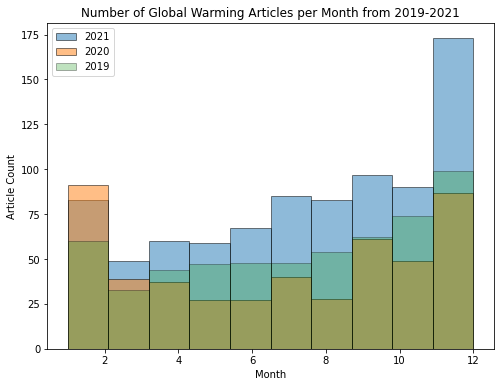

In [28]:
# Let's look at the frequency of 'Global Warming' Articles from
# 2019-2021 

gw_22 = df_news_gw.loc[df_news_gw['year'] == 2022]
gw_21 = df_news_gw.loc[df_news_gw['year'] == 2021]
gw_20 = df_news_gw.loc[df_news_gw['year'] == 2020]
gw_19 = df_news_gw.loc[df_news_gw['year'] == 2019]

plt.figure(figsize=(8,6))
plt.hist(gw_21.month, edgecolor = 'black', alpha = 0.5, label = '2021')
plt.hist(gw_20.month, edgecolor = 'black', alpha = 0.5, label = '2020')
plt.hist(gw_19.month, edgecolor = 'black', alpha = 0.3, label = '2019')
plt.title('Number of Global Warming Articles per Month from 2019-2021')
plt.xlabel('Month')
plt.ylabel('Article Count')

plt.legend(loc='upper left');






Looks like there's pretty good variation in the frequency of global warming related articles - meaning it could be a predictor of ETF volume. If the number of articles was even across the board, it would not be a good predictor.

### 1.3 NYT: Topic Modelling using Non-Negative Matrix Factorization (NMF)

In order to investigate whether using just the 'keywords' variable is the best method for extracting climate change related articles - I am going to implement a topic model to cluster similar texts and see if that gives me more article data to work with in my Time Series ETF model. 

When I first tried building my topic model I used Latent Dirichlet Allocation (see 1.3.A). However, finding the best parameters for the model took an extensive amount of time and resources. I decided to take a more scalable approach and implemented an NMF model: 

NMF is also an unsupervised learning technique. NMF factorizes high-dimensional vectors into lower-dimensional representation. This representation is composed of two matrices - one is the topics found and the other is the weights for the topics. NMF will modify the values of the topics and weights so that the product approaches the original matrix (the original text from the articles). 

I was able to process my text and build my topic model with the guidance of Rob Salgado who published his topic modelling work on towardsdatascience.com. 



#### 1.3.1 Creating text for NMF

In [30]:
def to_text(dataframe):
    df_news['headline_abstract'] = df_news.headline.str.cat(df_news.abstract, sep=' ', na_rep=' ')
    df_news['text'] = df_news.headline_abstract.str.cat(df_news.keywords, sep=' ', na_rep=' ')
    print('Number of articles: {}'.format(len(df)))
    

to_text(df_news)

/var/folders/2w/wbx4r95918vggzcgwttq04gh0000gn/T/ipykernel_1647/1429869230.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news['headline_abstract'] = df_news.headline.str.cat(df_news.abstract, sep=' ', na_rep=' ')


Number of articles: 687270


/var/folders/2w/wbx4r95918vggzcgwttq04gh0000gn/T/ipykernel_1647/1429869230.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news['text'] = df_news.headline_abstract.str.cat(df_news.keywords, sep=' ', na_rep=' ')


In [33]:
df_news.head(3)

,headline,date,doc_type,material_type,keywords,abstract,lead_paragraph,keywords_code,headline_abstract,text
0,Trump’s Book Club: A President Who Doesn’t Rea...,2018-12-01,article,News,"['Books and Literature', 'United States Politi...","President Trump, who is not a reader, has used...","WASHINGTON — President Trump, a leader who is ...","[Books and Literature, United States Politics ...",Trump’s Book Club: A President Who Doesn’t Rea...,Trump’s Book Club: A President Who Doesn’t Rea...
1,Kareem Hunt Is Cut by the Chiefs After a Video...,2018-12-01,article,News,"['Football', 'Domestic Violence']","Hunt, a star running back, was also suspended ...",The Kansas City Chiefs cut their star running ...,"[Football, Domestic Violence]",Kareem Hunt Is Cut by the Chiefs After a Video...,Kareem Hunt Is Cut by the Chiefs After a Video...
2,Agency Pulls Back on Its Warning Against Talk ...,2018-12-01,article,News,['Hatch Act (1939)'],Casual conversations about impeachment and inv...,"WASHINGTON — An independent government agency,...",[Hatch Act (1939)],Agency Pulls Back on Its Warning Against Talk ...,Agency Pulls Back on Its Warning Against Talk ...


In [34]:
# Upload necessary libraries 

import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

Extremely helpful text processing code from towardsdatascience.com:

In [35]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
import nltk

# Contraction map
c_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you you will",
    "you'll've": "you you will have",
    "you're": "you are",
    "you've": "you have"
}

# Compiling the contraction dict
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

# List of stop words
add_stop = ['said', 'say', '...', 'like', 'cnn', 'ad']
stop_words = ENGLISH_STOP_WORDS.union(add_stop)

# List of punctuation
punc = list(set(string.punctuation))


# Splits words on white spaces (leaves contractions intact) and splits out
# trailing punctuation
def casual_tokenizer(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens


def expandContractions(text, c_re=c_re):
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)


def process_text(text):
    text = casual_tokenizer(text)
    text = [each.lower() for each in text]
    text = [re.sub('[0-9]+', '', each) for each in text]
    text = [expandContractions(each, c_re=c_re) for each in text]
    text = [SnowballStemmer('english').stem(each) for each in text]
    text = [w for w in text if w not in punc]
    text = [w for w in text if w not in stop_words]
    text = [each for each in text if len(each) > 1]
    text = [each for each in text if ' ' not in each]
    return text


def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  


def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)


def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens


# Funtion to remove duplicate words
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist


def word_count(text):
    return len(str(text).split(' '))

In [36]:
# Process the text: 

df_news['processed_text'] = df_news['text'].apply(process_text)
df_news['processed_text']

/var/folders/2w/wbx4r95918vggzcgwttq04gh0000gn/T/ipykernel_1647/727389659.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news['processed_text'] = df_news['text'].apply(process_text)


0         [trump, book, club, presid, doesn, read, promo...
1         [kareem, hunt, cut, chief, video, attack, woma...
2         [agenc, pull, warn, talk, resist, feder, workp...
3         [china, hawk, gain, promin, trump, confront, x...
4         [wilmer, flore, met, fan, favorit, flore, did,...
                                ...                        
687263    [song, sunscreen, spread, health, insur, messa...
687264    [reluct, return, stage, sarah, phillip, introd...
687265    [met, declin, make, ani, met, remain, inact, b...
687267    [document, thatcher-reagan, rift, decis, invad...
687268    [crowd, return, las, vega, gambl, tourist, ret...
Name: processed_text, Length: 481553, dtype: object

In [38]:
df_news.head(3)

,headline,date,doc_type,material_type,keywords,abstract,lead_paragraph,keywords_code,headline_abstract,text,processed_text
0,Trump’s Book Club: A President Who Doesn’t Rea...,2018-12-01,article,News,"['Books and Literature', 'United States Politi...","President Trump, who is not a reader, has used...","WASHINGTON — President Trump, a leader who is ...","[Books and Literature, United States Politics ...",Trump’s Book Club: A President Who Doesn’t Rea...,Trump’s Book Club: A President Who Doesn’t Rea...,"[trump, book, club, presid, doesn, read, promo..."
1,Kareem Hunt Is Cut by the Chiefs After a Video...,2018-12-01,article,News,"['Football', 'Domestic Violence']","Hunt, a star running back, was also suspended ...",The Kansas City Chiefs cut their star running ...,"[Football, Domestic Violence]",Kareem Hunt Is Cut by the Chiefs After a Video...,Kareem Hunt Is Cut by the Chiefs After a Video...,"[kareem, hunt, cut, chief, video, attack, woma..."
2,Agency Pulls Back on Its Warning Against Talk ...,2018-12-01,article,News,['Hatch Act (1939)'],Casual conversations about impeachment and inv...,"WASHINGTON — An independent government agency,...",[Hatch Act (1939)],Agency Pulls Back on Its Warning Against Talk ...,Agency Pulls Back on Its Warning Against Talk ...,"[agenc, pull, warn, talk, resist, feder, workp..."


In [39]:
df_news['processed_text_string'] = ' '.join([str(item) for item in df_news['processed_text']])

/var/folders/2w/wbx4r95918vggzcgwttq04gh0000gn/T/ipykernel_1647/1562128937.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news['processed_text_string'] = ' '.join([str(item) for item in df_news['processed_text']])


In [40]:
# Get the average word count per text 
df_news['word_count'] = df_news['text'].apply(word_count)
df_news['word_count'].mean()

/var/folders/2w/wbx4r95918vggzcgwttq04gh0000gn/T/ipykernel_1647/2098387818.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news['word_count'] = df_news['text'].apply(word_count)


38.212479207896116

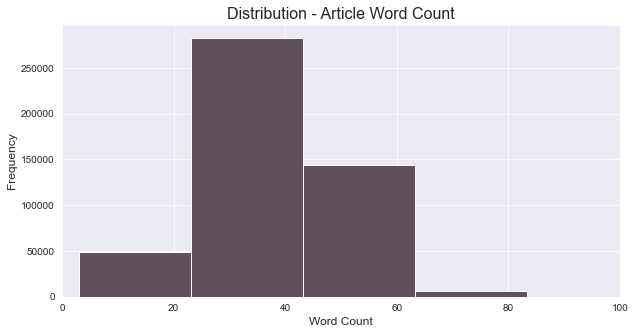

In [41]:
# Plot a hist of the word counts
fig = plt.figure(figsize=(10,5))

plt.hist(
    df_news['word_count'],
    bins=10,
    color='#60505C'
)

plt.title('Distribution - Article Word Count', fontsize=16)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Word Count', fontsize=12)
plt.xlim(0, 100)


plt.show();

In [42]:
# Get the top 20 most common words among all the articles
p_text = df_news['processed_text']

# Flaten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 20
top_20 = pd.DataFrame(
    Counter(p_text).most_common(20),
    columns=['word', 'frequency']
)

top_20

,word,frequency
0,new,95005
1,state,90780
2,unit,68743
3,polit,60439
4,govern,58779
5,elect,44877
6,year,38736
7,york,33442
8,trump,32597
9,presid,32573


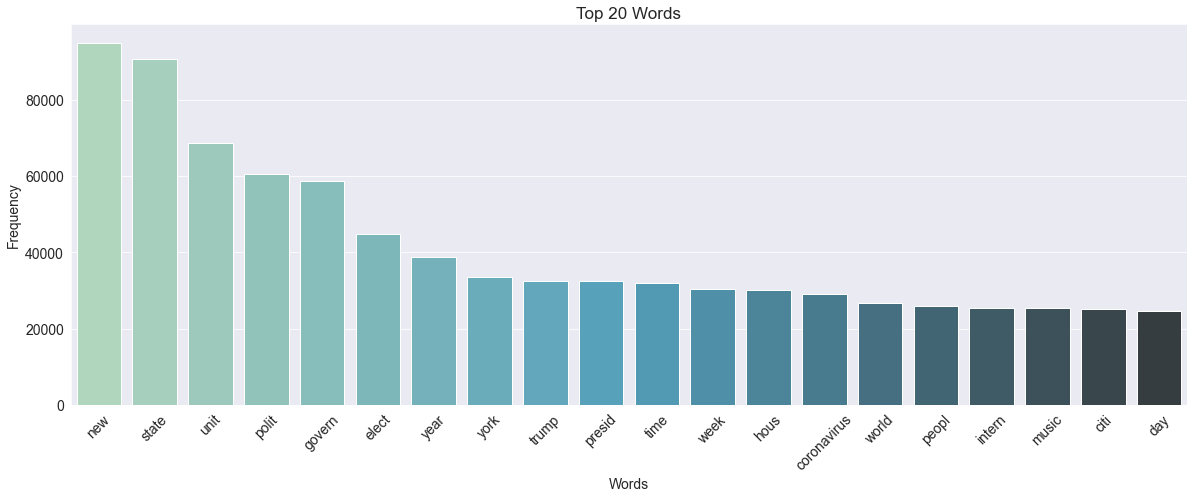

In [43]:
# Plot a bar chart for the top 20 most frequently occuring words
fig = plt.figure(figsize=(20,7))

g = sns.barplot(
    x='word',
    y='frequency',
    data=top_20,
    palette='GnBu_d'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 20 Words', fontsize=17)



plt.show()

Do not see climate change related text in any of the top words even after cleaning the text up. 

#### 1.3.2 Searching for the best number of topics using the coherence score

The coherence score measures how interpretable the topics are - overall it is a measure of how similar the words in the topic are to each other so that we as people can understand.

I decided to run 5-65 number of topics and determine which is the ideal number based on the highest coherence score.

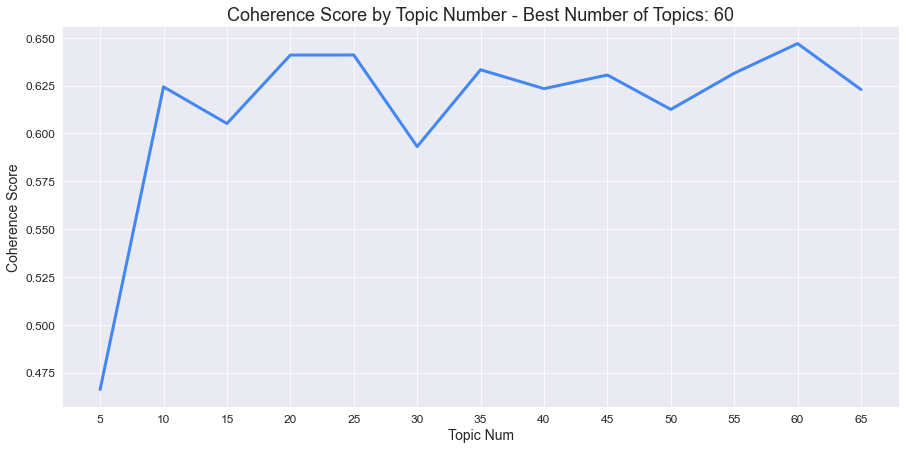

In [45]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = df_news['processed_text']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3, #filters out words that appear less than 3 times
    no_above=0.85, #filter out words that appear in >85% of the text
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 65 + 1, 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)


plt.show()

According to the coherence score, having a topic number of 60 fit the best

In [46]:
# Now use the number of topics with the 
# highest coherence score to run the 
# sklearn nmf model

texts = df_news['processed_text']

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names()

# Run the nmf model
nmf = NMF(
    n_components=60,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42
).fit(tfidf)

In [47]:
# Use the top words for each cluster by tfidf weight
# to create 'topics'

# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 8

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df.head()

,0,1,2,3,4,5,6,7,topics
0,polit,state,govern,polit govern,unit state,unit,state polit,senat,polit state govern unit senat
1,new,york,new york,citi,york citi,york time,mayor,york fashion,new york citi time mayor fashion
2,wed,wed engag,engag,coupl,met,coupl met,bride,groom,wed engag coupl met bride groom
3,estat,real estat,real,hous,residenti,estat hous,hous residenti,home,estat real hous residenti home
4,murder,attempt,attempt murder,murder attempt,homicid,murder homicid,kill,charg,murder attempt homicid kill charg


In [48]:
# Create a df with only the created topics and topic num
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df

,topic_num,topics
0,0,polit state govern unit senat
1,1,new york citi time mayor fashion
2,2,wed engag coupl met bride groom
3,3,estat real hous residenti home
4,4,murder attempt homicid kill charg
5,5,elect presidenti campaign democrat voter vote ...
6,6,fashion apparel week york men pari dress
7,7,word appear past year articl day time
8,8,puzzl crossword varieti solv acrost debut
9,9,book literatur writer write publish novel


Looks like topic 32 is where the climate change related articles are!

In [49]:
# Merging topic data to article dataset 

headline = df_news['headline'].tolist()

df_temp = pd.DataFrame({
    'headline': headline,
    'topic_num': docweights.argmax(axis=1)})

# Merging to get the topic num with url
merged_topic = df_temp.merge(
    topic_df,
    on='topic_num',
    how='left')

# Merging with the original df
df_topics = pd.merge(
    df_news,
    merged_topic,
    on='headline',
    how='left')

df_topics = df_topics.drop('processed_text',axis=1)

df_topics.head()


,headline,date,doc_type,material_type,keywords,abstract,lead_paragraph,keywords_code,headline_abstract,text,processed_text_string,word_count,topic_num,topics
0,Trump’s Book Club: A President Who Doesn’t Rea...,2018-12-01,article,News,"['Books and Literature', 'United States Politi...","President Trump, who is not a reader, has used...","WASHINGTON — President Trump, a leader who is ...","[Books and Literature, United States Politics ...",Trump’s Book Club: A President Who Doesn’t Rea...,Trump’s Book Club: A President Who Doesn’t Rea...,"['trump', 'book', 'club', 'presid', 'doesn', '...",53,38,trump presid impeach donald russian interfer
1,Kareem Hunt Is Cut by the Chiefs After a Video...,2018-12-01,article,News,"['Football', 'Domestic Violence']","Hunt, a star running back, was also suspended ...",The Kansas City Chiefs cut their star running ...,"[Football, Domestic Violence]",Kareem Hunt Is Cut by the Chiefs After a Video...,Kareem Hunt Is Cut by the Chiefs After a Video...,"['trump', 'book', 'club', 'presid', 'doesn', '...",51,54,video record stream download televis
2,Agency Pulls Back on Its Warning Against Talk ...,2018-12-01,article,News,['Hatch Act (1939)'],Casual conversations about impeachment and inv...,"WASHINGTON — An independent government agency,...",[Hatch Act (1939)],Agency Pulls Back on Its Warning Against Talk ...,Agency Pulls Back on Its Warning Against Talk ...,"['trump', 'book', 'club', 'presid', 'doesn', '...",40,38,trump presid impeach donald russian interfer
3,A China Hawk Gains Prominence as Trump Confron...,2018-12-01,article,News,"['United States International Relations', 'Uni...","Michael Pillsbury, the president’s top outside...",WASHINGTON — Michael Pillsbury had just finish...,"[United States International Relations, United...",A China Hawk Gains Prominence as Trump Confron...,A China Hawk Gains Prominence as Trump Confron...,"['trump', 'book', 'club', 'presid', 'doesn', '...",45,47,relat intern state unit nuclear
4,Wilmer Flores Is a Met No More,2018-12-01,article,News,['Baseball'],"A fan favorite, Flores did not receive a contr...","The Mets parted ways with a fan favorite, Wilm...",[Baseball],"Wilmer Flores Is a Met No More A fan favorite,...","Wilmer Flores Is a Met No More A fan favorite,...","['trump', 'book', 'club', 'presid', 'doesn', '...",28,12,basebal yanke season met team run sport footbal


In [50]:
topic_32 = df_topics[df_topics['topic_num'] == 32]
topic_32

,headline,date,doc_type,material_type,keywords,abstract,lead_paragraph,keywords_code,headline_abstract,text,processed_text_string,word_count,topic_num,topics
144,11 of Our Best Weekend Reads,2018-12-01,article,News,"['#MeToo Movement', 'Missionaries']",The unsettling reality behind a Louisiana scho...,Welcome to the Weekend. It’s the first one in ...,"[#MeToo Movement, Missionaries]",11 of Our Best Weekend Reads The unsettling re...,11 of Our Best Weekend Reads The unsettling re...,"['trump', 'book', 'club', 'presid', 'doesn', '...",40,32,warm global climat gas emiss greenhous
160,11 of Our Best Weekend Reads,2018-12-01,article,News,"['#MeToo Movement', 'Missionaries']",The unsettling reality behind a Louisiana scho...,Welcome to the Weekend. It’s the first one in ...,"[#MeToo Movement, Missionaries]",11 of Our Best Weekend Reads The unsettling re...,11 of Our Best Weekend Reads The unsettling re...,"['trump', 'book', 'club', 'presid', 'doesn', '...",40,32,warm global climat gas emiss greenhous
161,11 of Our Best Weekend Reads,2018-12-01,article,News,"['#MeToo Movement', 'Missionaries']",The unsettling reality behind a Louisiana scho...,Welcome to the Weekend. It’s the first one in ...,"[#MeToo Movement, Missionaries]",11 of Our Best Weekend Reads The unsettling re...,11 of Our Best Weekend Reads The unsettling re...,"['trump', 'book', 'club', 'presid', 'doesn', '...",40,32,warm global climat gas emiss greenhous
185,11 of Our Best Weekend Reads,2018-12-01,article,News,"['#MeToo Movement', 'Missionaries']",The unsettling reality behind a Louisiana scho...,Welcome to the Weekend. It’s the first one in ...,"[#MeToo Movement, Missionaries]",11 of Our Best Weekend Reads The unsettling re...,11 of Our Best Weekend Reads The unsettling re...,"['trump', 'book', 'club', 'presid', 'doesn', '...",40,32,warm global climat gas emiss greenhous
350,Betting on a new way to make concrete that doe...,2018-12-02,article,News,"['Concrete', 'Greenhouse Gas Emissions', 'Carb...",A New Jersey firm is experimenting in a small ...,"LEIGHTON BUZZARD, England — Just after sunrise...","[Concrete, Greenhouse Gas Emissions, Carbon Di...",Betting on a new way to make concrete that doe...,Betting on a new way to make concrete that doe...,"['trump', 'book', 'club', 'presid', 'doesn', '...",50,32,warm global climat gas emiss greenhous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1957578,A Mexican Slick,2013-07-30,article,News,"['Nationalization of Industry', 'Oil (Petroleu...",A proposal to partly privatize Mexico’s energy...,"MEXICO CITY — Andrés Manuel López Obrador, the...","[Nationalization of Industry, Oil (Petroleum) ...",A Mexican Slick A proposal to partly privatize...,A Mexican Slick A proposal to partly privatize...,"['trump', 'book', 'club', 'presid', 'doesn', '...",27,32,warm global climat gas emiss greenhous
1957757,Fight Over Plan for Natural Gas Port Off Long ...,2013-07-31,article,News,"['Natural Gas', 'Environment', 'Energy and Pow...",Supporters say the port would create jobs and ...,Some fishermen call the waters some 20 miles o...,"[Natural Gas, Environment, Energy and Power]",Fight Over Plan for Natural Gas Port Off Long ...,Fight Over Plan for Natural Gas Port Off Long ...,"['trump', 'book', 'club', 'presid', 'doesn', '...",41,32,warm global climat gas emiss greenhous
1957781,"Bills Unpaid, Power Is Cut to Province in Phil...",2013-07-31,article,News,['Electric Light and Power'],More than one million people lost electricity ...,MANILA — A Philippine province of 1.2 million ...,[Electric Light and Power],"Bills Unpaid, Power Is Cut to Province in Phil...","Bills Unpaid, Power Is Cut to Province in Phil...","['trump', 'book', 'club', 'presid', 'doesn', '...",38,32,warm global climat gas emiss greenhous
1957799,Milestone Claimed in Creating Fuel From Waste,2013-07-31,article,News,"['Ethanol', 'Alternative and Renewable Energy'...",In what would be a key breakthrough for renewa...,WASHINGTON — After months of frustrating delay.

Clean up the data:

In [51]:
topic_32.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9235 entries, 144 to 1957883
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   headline               9235 non-null   object
 1   date                   9235 non-null   object
 2   doc_type               9235 non-null   object
 3   material_type          9235 non-null   object
 4   keywords               9235 non-null   object
 5   abstract               9235 non-null   object
 6   lead_paragraph         9181 non-null   object
 7   keywords_code          9235 non-null   object
 8   headline_abstract      9235 non-null   object
 9   text                   9235 non-null   object
 10  processed_text_string  9235 non-null   object
 11  word_count             9235 non-null   int64 
 12  topic_num              9235 non-null   int64 
 13  topics                 9235 non-null   object
dtypes: int64(2), object(12)
memory usage: 1.1+ MB


No nulls - what about duplicates:

In [56]:
# Only want headline, date, topic num, and topics 

topic_32_clean = topic_32.drop(['doc_type', 'material_type', 'abstract', 'lead_paragraph','text', 'word_count', 'headline_abstract', 'processed_text_string'], axis = 1)






In [57]:
topic_32_clean

,headline,date,keywords,keywords_code,topic_num,topics
144,11 of Our Best Weekend Reads,2018-12-01,"['#MeToo Movement', 'Missionaries']","[#MeToo Movement, Missionaries]",32,warm global climat gas emiss greenhous
160,11 of Our Best Weekend Reads,2018-12-01,"['#MeToo Movement', 'Missionaries']","[#MeToo Movement, Missionaries]",32,warm global climat gas emiss greenhous
161,11 of Our Best Weekend Reads,2018-12-01,"['#MeToo Movement', 'Missionaries']","[#MeToo Movement, Missionaries]",32,warm global climat gas emiss greenhous
185,11 of Our Best Weekend Reads,2018-12-01,"['#MeToo Movement', 'Missionaries']","[#MeToo Movement, Missionaries]",32,warm global climat gas emiss greenhous
350,Betting on a new way to make concrete that doe...,2018-12-02,"['Concrete', 'Greenhouse Gas Emissions', 'Carb...","[Concrete, Greenhouse Gas Emissions, Carbon Di...",32,warm global climat gas emiss greenhous
...,...,...,...,...,...,...
1957578,A Mexican Slick,2013-07-30,"['Nationalization of Industry', 'Oil (Petroleu...","[Nationalization of Industry, Oil (Petroleum) ...",32,warm global climat gas emiss greenhous
1957757,Fight Over Plan for Natural Gas Port Off Long ...,2013-07-31,"['Natural Gas', 'Environment', 'Energy and Pow...","[Natural Gas, Environment, Energy and Power]",32,warm global climat gas emiss greenhous
1957781,"Bills Unpaid, Power Is Cut to Province in Phil...",2013-07-31,['Electric Light and Power'],[Electric Light and Power],32,warm global climat gas emiss greenhous
1957799,Milestone Claimed in Creating Fuel From Waste,2013-07-31,"['Ethanol', 'Alternative and Renewable Energy'...","[Ethanol, Alternative and Renewable Energy, Gr...",32,warm global climat gas emiss greenhous


In [60]:
# Look for duplicates 

topic_32_clean['headline'].duplicated().value_counts()

False    8307
True      928
Name: headline, dtype: int64

In [61]:
topic_32_clean[topic_32_clean['headline'].duplicated()]

,headline,date,keywords,keywords_code,topic_num,topics
160,11 of Our Best Weekend Reads,2018-12-01,"['#MeToo Movement', 'Missionaries']","[#MeToo Movement, Missionaries]",32,warm global climat gas emiss greenhous
161,11 of Our Best Weekend Reads,2018-12-01,"['#MeToo Movement', 'Missionaries']","[#MeToo Movement, Missionaries]",32,warm global climat gas emiss greenhous
185,11 of Our Best Weekend Reads,2018-12-01,"['#MeToo Movement', 'Missionaries']","[#MeToo Movement, Missionaries]",32,warm global climat gas emiss greenhous
3291,11 of Our Best Weekend Reads,2018-12-08,"['Christmas', 'Mental Health and Disorders']","[Christmas, Mental Health and Disorders]",32,warm global climat gas emiss greenhous
3307,11 of Our Best Weekend Reads,2018-12-08,"['Christmas', 'Mental Health and Disorders']","[Christmas, Mental Health and Disorders]",32,warm global climat gas emiss greenhous
...,...,...,...,...,...,...
1924627,11 of Our Best Weekend Reads,2020-08-28,[],[],32,warm global climat gas emiss greenhous
1924643,11 of Our Best Weekend Reads,2020-08-28,[],[],32,warm global climat gas emiss greenhous
1924644,11 of Our Best Weekend Reads,2020-08-28,[],[],32,warm global climat gas emiss greenhous
1924668,11 of Our Best Weekend Reads,2020-08-28,[],[],32,warm global climat gas emiss greenhous


In [63]:
# Remove the best weekend reads section 

topic_32_clean[topic_32_clean['headline'].str.contains('11 of Our Best Weekend Reads')]


,headline,date,keywords,keywords_code,topic_num,topics
144,11 of Our Best Weekend Reads,2018-12-01,"['#MeToo Movement', 'Missionaries']","[#MeToo Movement, Missionaries]",32,warm global climat gas emiss greenhous
160,11 of Our Best Weekend Reads,2018-12-01,"['#MeToo Movement', 'Missionaries']","[#MeToo Movement, Missionaries]",32,warm global climat gas emiss greenhous
161,11 of Our Best Weekend Reads,2018-12-01,"['#MeToo Movement', 'Missionaries']","[#MeToo Movement, Missionaries]",32,warm global climat gas emiss greenhous
185,11 of Our Best Weekend Reads,2018-12-01,"['#MeToo Movement', 'Missionaries']","[#MeToo Movement, Missionaries]",32,warm global climat gas emiss greenhous
3291,11 of Our Best Weekend Reads,2018-12-08,"['Christmas', 'Mental Health and Disorders']","[Christmas, Mental Health and Disorders]",32,warm global climat gas emiss greenhous
...,...,...,...,...,...,...
1922209,11 of Our Best Weekend Reads,2020-08-21,[],[],32,warm global climat gas emiss greenhous
1924627,11 of Our Best Weekend Reads,2020-08-28,[],[],32,warm global climat gas emiss greenhous
1924643,11 of Our Best Weekend Reads,2020-08-28,[],[],32,warm global climat gas emiss greenhous
1924644,11 of Our Best Weekend Reads,2020-08-28,[],[],32,warm global climat gas emiss greenhous


In [65]:
topic_32_clean.drop(topic_32_clean.loc[topic_32_clean['headline'].str.contains('11 of Our Best Weekend Reads')].index, inplace = True)





In [68]:
topic_32_clean['headline'].duplicated().value_counts()

False    8306
True      365
Name: headline, dtype: int64

In [69]:
topic_32_clean[topic_32_clean['headline'].duplicated()]

,headline,date,keywords,keywords_code,topic_num,topics
33796,Variety: Acrostic,2019-01-05,[],[],32,warm global climat gas emiss greenhous
39647,Variety: Acrostic,2019-01-19,"['Crossword Puzzles', 'Acrostic Puzzles']","[Crossword Puzzles, Acrostic Puzzles]",32,warm global climat gas emiss greenhous
48116,Variety: Acrostic,2020-05-09,[],[],32,warm global climat gas emiss greenhous
53030,Variety: Acrostic,2020-05-23,['Opera'],[Opera],32,warm global climat gas emiss greenhous
59685,Variety: Acrostic,2020-04-11,['Acrostic Puzzles'],[Acrostic Puzzles],32,warm global climat gas emiss greenhous
...,...,...,...,...,...,...
1915143,Variety: Acrostic,2020-08-01,['Crossword Puzzles'],[Crossword Puzzles],32,warm global climat gas emiss greenhous
1919859,Variety: Acrostic,2020-08-15,['Crossword Puzzles'],[Crossword Puzzles],32,warm global climat gas emiss greenhous
1922033,Why Does California Have So Many Wildfires?,2020-08-21,"['Global Warming', 'Environment', 'Greenhouse ...","[Global Warming, Environment, Greenhouse Gas E...",32,warm global climat gas emiss greenhous
1922034,Why Does California Have So Many Wildfires?,2020-08-21,"['Global Warming', 'Environment', 'Greenhouse ...","[Global Warming, Environment, Greenhouse Gas E...",32,warm global climat gas emiss greenhous


In [71]:
topic_32_clean.drop(topic_32_clean.loc[topic_32_clean['headline'].str.contains('Variety: Acrostic')].index, inplace = True)


In [72]:
topic_32_clean['headline'].duplicated().value_counts()

False    8305
True      229
Name: headline, dtype: int64

In [73]:
topic_32_clean[topic_32_clean['headline'].duplicated()]

,headline,date,keywords,keywords_code,topic_num,topics
74287,What We’re Reading Now,2013-09-27,[],[],32,warm global climat gas emiss greenhous
79498,Why Does California Have So Many Wildfires?,2018-11-10,"['Wildfires', 'Global Warming', 'Forests and F...","[Wildfires, Global Warming, Forests and Forest...",32,warm global climat gas emiss greenhous
106440,What We’re Reading Now,2014-11-13,['Agriculture and Farming'],[Agriculture and Farming],32,warm global climat gas emiss greenhous
177279,Stuff We Liked,2014-10-10,['Polls and Public Opinion'],[Polls and Public Opinion],32,warm global climat gas emiss greenhous
182779,What We’re Reading Now,2014-10-17,"['Artificial Sweeteners', ""Farmers' Markets"", ...","[Artificial Sweeteners, Farmers' Markets, Food...",32,warm global climat gas emiss greenhous
...,...,...,...,...,...,...
1818525,What We’re Reading Now,2015-02-27,['Minimum Wage'],[Minimum Wage],32,warm global climat gas emiss greenhous
1855930,Inflation Nation Not,2013-06-16,[],[],32,warm global climat gas emiss greenhous
1914036,What We’re Reading Now,2015-01-30,"['Food Stamps', 'Super Bowl']","[Food Stamps, Super Bowl]",32,warm global climat gas emiss greenhous
1922033,Why Does California Have So Many Wildfires?,2020-08-21,"['Global Warming', 'Environment', 'Greenhouse ...","[Global Warming, Environment, Greenhouse Gas E...",32,warm global climat gas emiss greenhous


#### 1.3.3 Topic Exploration: exploring the topic - total of 8534 articles

In [78]:
topic_32_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8534 entries, 350 to 1957883
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   headline       8534 non-null   object        
 1   date           8534 non-null   datetime64[ns]
 2   keywords       8534 non-null   object        
 3   keywords_code  8534 non-null   object        
 4   topic_num      8534 non-null   int64         
 5   topics         8534 non-null   object        
 6   year           8534 non-null   int64         
 7   month          8534 non-null   int64         
 8   day            8534 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 666.7+ KB


In [75]:
# Make data, datetime 

from datetime import datetime as dt

topic_32_clean['date'] = pd.to_datetime(topic_32_clean['date'])

topic_32_clean['year'] = topic_32_clean['date'].dt.year
topic_32_clean['month'] = topic_32_clean['date'].dt.month
topic_32_clean['day'] = topic_32_clean['date'].dt.day




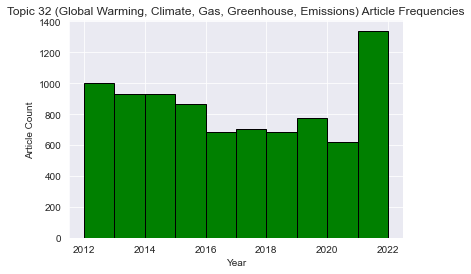

In [76]:
plt.hist(topic_32_clean.year, edgecolor = 'black', color = 'green')
plt.title('Topic 32 (Global Warming, Climate, Gas, Greenhouse, Emissions) Article Frequencies')
plt.xlabel('Year')
plt.ylabel('Article Count');

Articles related to climate change started to take a dip around the time Trump became president and then again during the pandemic. The number of articles shot up during 2021. 

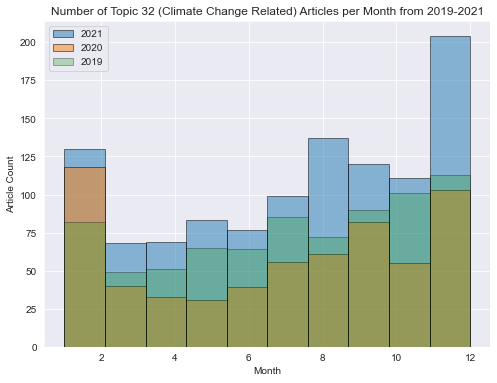

In [80]:
# Look more closely at monthly rates 


T32_21 = topic_32_clean.loc[topic_32_clean['year'] == 2021]
T32_20 = topic_32_clean.loc[topic_32_clean['year'] == 2020]
T32_19 = topic_32_clean.loc[topic_32_clean['year'] == 2019]

plt.figure(figsize=(8,6))
plt.hist(T32_21.month, edgecolor = 'black', alpha = 0.5, label = '2021')
plt.hist(T32_20.month, edgecolor = 'black', alpha = 0.5, label = '2020')
plt.hist(T32_19.month, edgecolor = 'black', alpha = 0.3, label = '2019')
plt.title('Number of Topic 32 (Climate Change Related) Articles per Month from 2019-2021')
plt.xlabel('Month')
plt.ylabel('Article Count')

plt.legend(loc='upper left');

See the climate related articles dip in 2020 at the start of the pandemic, but increased tremendously over the course of 2021. 

Also interested to dive in more to the keywords for the articles in the topic of interest field.

In [82]:
# Interested to also see keywords 

def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

topic_32_clean['keywords_code'] = topic_32_clean['keywords'].apply(eval)

to_1D(topic_32_clean['keywords_code'])

0                            Concrete
1            Greenhouse Gas Emissions
2                      Carbon Dioxide
3                          Innovation
4         Factories and Manufacturing
                     ...             
35017            Hydraulic Fracturing
35018          Inventions and Patents
35019                     Natural Gas
35020    Oil (Petroleum) and Gasoline
35021                           Shale
Length: 35022, dtype: object

In [83]:
to_1D(topic_32_clean['keywords_code']).value_counts().head(25)

Global Warming                                           3898
Greenhouse Gas Emissions                                 2587
Oil (Petroleum) and Gasoline                             1031
Environment                                               920
United States Politics and Government                     829
Carbon Dioxide                                            670
Alternative and Renewable Energy                          626
Air Pollution                                             565
Natural Gas                                               549
United Nations Framework Convention on Climate Change     500
Weather                                                   474
Regulation and Deregulation of Industry                   461
Floods                                                    456
Coal                                                      449
Electric Light and Power                                  394
Hurricanes and Tropical Storms                            357
Wildfire

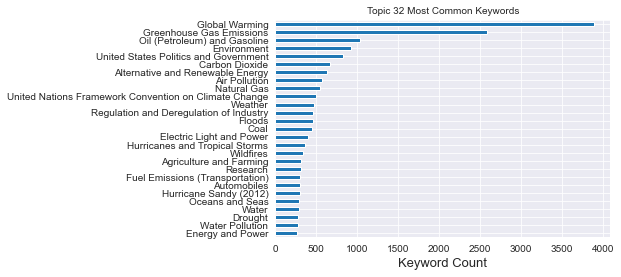

In [86]:
to_1D(topic_32_clean['keywords_code']).value_counts(ascending=True).loc[to_1D(topic_32_clean['keywords_code']).value_counts() > 250].plot(kind='barh')

plt.title('Topic 32 Most Common Keywords', fontsize=10)
plt.xlabel('Keyword Count', fontsize=13)
plt.show()

Based on the most common keywords it looks like the NMF model did a pretty good job! Going to use this article count information for the time series model.

#### 1.3.A First Topic Modelling Attempt - (LDA Work: NYT: LDA Topic Modelling)

Before running my NMF topic model I attempted my model with LDA - my thought process was as follows:

I am using Latent Dirichlet Allocation (LDA) which is a "generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities" (towardsdatascience.com).  

##### 1.3.A.1 Creating a text column with headline, keyword, and abstract text

In [108]:
def to_text(dataframe):
    df_news['headline_abstract'] = df_news.headline.str.cat(df_news.abstract, sep=' ', na_rep=' ')
    df_news['text'] = df_news.headline_abstract.str.cat(df_news.keywords, sep=' ', na_rep=' ')
    print('Number of articles: {}'.format(len(df)))
    

to_text(df_news)

/var/folders/2w/wbx4r95918vggzcgwttq04gh0000gn/T/ipykernel_14244/1429869230.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news['headline_abstract'] = df_news.headline.str.cat(df_news.abstract, sep=' ', na_rep=' ')


Number of articles: 687270


/var/folders/2w/wbx4r95918vggzcgwttq04gh0000gn/T/ipykernel_14244/1429869230.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news['text'] = df_news.headline_abstract.str.cat(df_news.keywords, sep=' ', na_rep=' ')


In [109]:
df_news.head(2)

,headline,date,doc_type,material_type,keywords,abstract,lead_paragraph,keywords_code,headline_abstract,text
0,Trump’s Book Club: A President Who Doesn’t Rea...,2018-12-01,article,News,"['Books and Literature', 'United States Politi...","President Trump, who is not a reader, has used...","WASHINGTON — President Trump, a leader who is ...","[Books and Literature, United States Politics ...",Trump’s Book Club: A President Who Doesn’t Rea...,Trump’s Book Club: A President Who Doesn’t Rea...
1,Kareem Hunt Is Cut by the Chiefs After a Video...,2018-12-01,article,News,"['Football', 'Domestic Violence']","Hunt, a star running back, was also suspended ...",The Kansas City Chiefs cut their star running ...,"[Football, Domestic Violence]",Kareem Hunt Is Cut by the Chiefs After a Video...,Kareem Hunt Is Cut by the Chiefs After a Video...


##### 1.3.A.2 Preparing data for LDA analysis

In [110]:
# Load the regular expression library 
import re 

# Remove punctuation 
df_news['text'] = \
df_news['text'].map(lambda a: re.sub('[(,\/.!:;?)]', '', a))

# Convert to all lowercase 

df_news['text'] = \
df_news['text'].map(lambda x: x.lower())

# Print out the first rows of articles 
df_news['text'].head()

/var/folders/2w/wbx4r95918vggzcgwttq04gh0000gn/T/ipykernel_14244/2874981034.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news['text'] = \
/var/folders/2w/wbx4r95918vggzcgwttq04gh0000gn/T/ipykernel_14244/2874981034.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news['text'] = \


0    trump’s book club a president who doesn’t read...
1    kareem hunt is cut by the chiefs after a video...
2    agency pulls back on its warning against talk ...
3    a china hawk gains prominence as trump confron...
4    wilmer flores is a met no more a fan favorite ...
Name: text, dtype: object

Some fun visualization of the text with wordcloud

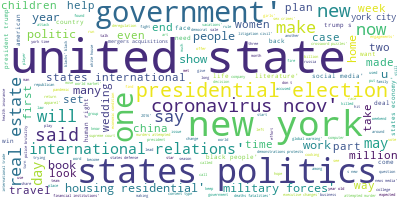

In [113]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(df_news['text'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

Not seeing anything related to global warming or climate change...

In [111]:
# Remove stop words 

import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eapresident/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [114]:
stop_words = stopwords.words('english')

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = df_news.text.values.tolist()


# remove stop words
data_words = remove_stopwords(data)

print(data_words[:1][0][:30])

['trump', 'book', 'club', 'president', 'read', 'promotes', 'books', 'promote', 'president', 'trump', 'reader', 'used', 'twitter', 'plug', 'slew', 'trump', 'friendly', 'books', 'titles', 'like', 'fight', 'russia', 'hoax', 'books', 'literature', 'united', 'states', 'politics', 'government', 'presidents']


In [115]:
# Create my corpus (dictionary) to use for my model 

import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])



[(0, 1), (1, 3), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 3), (23, 1), (24, 1), (25, 1), (26, 1)]


##### 1.3.A.3 LDA Model

In [116]:
from pprint import pprint

# number of topics
num_topics = 30


# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(8,
  '0.043*"new" + 0.031*"york" + 0.026*"city" + 0.023*"children" + '
  '0.020*"education" + 0.019*"school" + 0.012*"family" + 0.010*"childhood" + '
  '0.010*"mayor" + 0.010*"puzzles"'),
 (19,
  '0.030*"ice" + 0.027*"hockey" + 0.017*"sexual" + 0.014*"harassment" + '
  '0.008*"gender" + 0.007*"movement" + 0.007*"nhl" + 0.006*"bay" + '
  '0.006*"stanley" + 0.005*"camp"'),
 (18,
  '0.062*"fashion" + 0.041*"week" + 0.031*"new" + 0.029*"apparel" + '
  '0.018*"york" + 0.014*"paris" + 0.013*"men" + 0.009*"automobiles" + '
  '0.008*"diary" + 0.008*"show"'),
 (23,
  '0.027*"labor" + 0.012*"jobs" + 0.011*"workers" + 0.010*"organized" + '
  '0.009*"union" + 0.009*"day" + 0.009*"wages" + 0.008*"work" + '
  '0.007*"salaries" + 0.007*"lesson"'),
 (16,
  '0.027*"basketball" + 0.023*"college" + 0.023*"games" + 0.020*"football" + '
  '0.019*"game" + 0.015*"sports" + 0.013*"year" + 0.011*"word" + 0.011*"day" + '
  '0.011*"season"'),
 (11,
  '0.025*"love" + 0.014*"times" + 0.012*"readers" + 0.010*"dat

In [141]:
pyLDAvis.enable_notebook()

In [144]:
# Visualize the topics

import pyLDAvis
import pyLDAvis.sklearn
import pickle 
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook(local = True)

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared


/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
6     -0.161433  0.064094       1        1  7.682651
3     -0.087499 -0.061649       2        1  4.945512
4     -0.174227 -0.165717       3        1  4.752588
20     0.177604  0.057358       4        1  4.716294
9     -0.004132 -0.127485       5        1  4.600184
16     0.110238  0.034850       6        1  4.433907
17    -0.043729 -0.157116       7        1  4.362345
8      0.076051 -0.062408       8        1  4.208039
24    -0.177387  0.099181       9        1  4.092342
28    -0.209029  0.009688      10        1  3.982341
14     0.134735  0.047144      11        1  3.652727
1     -0.058970  0.209164      12        1  3.638921
27     0.127584 -0.099422      13        1  3.593345
26     0.197216  0.043065      14        1  3.357927
12    -0.014250  0.185235      15        1  3.131768
18     0.198732  0.006752      16        1  3.123811
0      0.031661  0.020867      17        1  2.973551
29    -0.133644 -0.019764      18        1  2.955331
22     0.118638 -0.067284      19        1  2.806106
7     -0.089044 -0.186885      20        1  2.558356
25    -0.107895  0.037868      21        1  2.557631
2      0.107089 -0.009669      22        1  2.513229
21     0.021986  0.070317      23        1  2.246058
5     -0.158732  0.036435      24        1  2.176815
11     0.122513 -0.045736      25        1  2.143069
15    -0.024742  0.184980      26        1  1.921797
13    -0.014724 -0.020798      27        1  1.772442
23     0.027141 -0.100762      28        1  1.748222
10    -0.030377  0.002693      29        1  1.717479
19     0.038625  0.015003      30        1  1.635211, topic_info=               Term          Freq         Total Category  logprob  loglift
20           states  67474.000000  67474.000000  Default  30.0000  30.0000
1489           news  26568.000000  26568.000000  Default  29.0000  29.0000
24           united  65723.000000  65723.000000  Default  28.0000  28.0000
492         fashion  23236.000000  23236.000000  Default  27.0000  27.0000
22            trump  33876.000000  33876.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
618        training    782.758659   2081.633783  Topic30  -5.5289   3.1353
15840      thoughts    514.310268    766.850347  Topic30  -5.9489   3.7139
3171          speed    587.720384   1515.130941  Topic30  -5.8154   3.1664
2860        someone    546.911496   1122.211187  Topic30  -5.8874   3.3946
1169   philadelphia    551.337280   1238.798450  Topic30  -5.8794   3.3038

[2176 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
6434       2  0.003949  aaron
6434      12  0.001316  aaron
6434      30  0.992475  aaron
9559      10  0.996239  abbey
18207     24  0.995797    abe
...      ...       ...    ...
454       28  0.001842   york
454       29  0.000084   york
454       30  0.000335   york
28079     13  0.997295   zack
23172     20  0.998090   zika

[14376 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 5, 21, 10, 17, 18, 9, 25, 29, 15, 2, 28, 27, 13, 19, 1, 30, 23, 8, 26, 3, 22, 6, 12, 16, 14, 24, 11, 20])

Based on the topic visualizations, topic 15 appears to cluster documents related to climate change, renewable energy, etc. Interested in a few of the most frequent words: 

- Energy 
- Emissions
- Greenhouse



In [155]:
# Let's search for these terms 

df_news_energy = df_news[df_news['text'].str.contains('energy')]
df_news_energy.head(5)


,headline,date,doc_type,material_type,keywords,abstract,lead_paragraph,keywords_code,headline_abstract,text
604,"As OPEC Meets, Sizing Up Its Power and Its Pol...",2018-12-05,article,News,"['Oil (Petroleum) and Gasoline', 'Prices (Fare...",OPEC’s gathering in Vienna comes at a tricky t...,"VIENNA — On Thursday, over 200 oil industry re...","[Oil (Petroleum) and Gasoline, Prices (Fares, ...","As OPEC Meets, Sizing Up Its Power and Its Pol...",as opec meets sizing up its power and its poli...
780,"On First Day of OPEC Meetings, No Deal to Cut ...",2018-12-06,article,News,"['Oil (Petroleum) and Gasoline', 'United State...","Khalid al-Falih, the Saudi energy minister, sa...",VIENNA — OPEC ended a meeting on Thursday with...,"[Oil (Petroleum) and Gasoline, United States I...","On First Day of OPEC Meetings, No Deal to Cut ...",on first day of opec meetings no deal to cut g...
912,U.S. Oil Exports Are Rising. So Is the Trade D...,2018-12-07,article,News,"['United States Economy', 'International Trade...",The Trump administration has touted increased ...,WASHINGTON — The United States exported more o...,"[United States Economy, International Trade an...",U.S. Oil Exports Are Rising. So Is the Trade D...,us oil exports are rising so is the trade defi...
917,Joe Manchin Faces Liberal Opposition in Bid to...,2018-12-07,article,News,"['United States Politics and Government', 'Ele...",The West Virginia senator’s support for coal h...,WASHINGTON — During his first run for the Sena...,"[United States Politics and Government, Electi...",Joe Manchin Faces Liberal Opposition in Bid to...,joe manchin faces liberal opposition in bid to...
972,U.S.-China Friction Threatens to Undercut the ...,2018-12-07,article,News,"['Global Warming', 'United States Internationa...",Distrust between the two biggest greenhouse ga...,They have the largest carbon footprints. Also ...,"[Global Warming, United States International R...",U.S.-China Friction Threatens to Undercut the ...,us-china friction threatens to undercut the fi...


In [159]:
def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

df_news_energy['keywords_code'] = df_news_energy['keywords'].apply(eval)

to_1D(df_news_energy['keywords_code'])

/var/folders/2w/wbx4r95918vggzcgwttq04gh0000gn/T/ipykernel_14244/420020923.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news_energy['keywords_code'] = df_news_energy['keywords'].apply(eval)


0                 Oil (Petroleum) and Gasoline
1               Prices (Fares, Fees and Rates)
2         International Trade and World Market
3                 Oil (Petroleum) and Gasoline
4        United States International Relations
                         ...                  
15160                     Hydraulic Fracturing
15161                   Inventions and Patents
15162                              Natural Gas
15163             Oil (Petroleum) and Gasoline
15164                                    Shale
Length: 15165, dtype: object

In [161]:
to_1D(df_news_energy['keywords_code']).value_counts()

Alternative and Renewable Energy    810
Global Warming                      652
Greenhouse Gas Emissions            618
Nuclear Energy                      566
Oil (Petroleum) and Gasoline        502
                                   ... 
internal-paywall-exempt               1
Firearms                              1
Whites                                1
Recalls and Bans of Products          1
Wetlands                              1
Length: 1216, dtype: int64

In [170]:
#Emissions

df_news_emissions = df_news[df_news['text'].str.contains('emissions')]

def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

df_news_emissions['keywords_code'] = df_news_emissions['keywords'].apply(eval)

to_1D(df_news_emissions['keywords_code'])

/var/folders/2w/wbx4r95918vggzcgwttq04gh0000gn/T/ipykernel_14244/2003137967.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news_emissions['keywords_code'] = df_news_emissions['keywords'].apply(eval)


0                                Concrete
1                Greenhouse Gas Emissions
2                          Carbon Dioxide
3                              Innovation
4             Factories and Manufacturing
                       ...               
18032                             Ethanol
18033    Alternative and Renewable Energy
18034            Greenhouse Gas Emissions
18035              Bioenergy and Biofuels
18036                             Methane
Length: 18037, dtype: object

In [171]:
to_1D(df_news_emissions['keywords_code']).value_counts()

Greenhouse Gas Emissions                 2744
Global Warming                           2130
Carbon Dioxide                            631
United States Politics and Government     582
Environment                               531
                                         ... 
Biometrics                                  1
Airports                                    1
Endorsements                                1
Nonfungible Tokens (NFTs)                   1
Demonstrations, Protests, and Riots         1
Length: 1013, dtype: int64

In [172]:
#Emissions

df_news_greenhouse = df_news[df_news['text'].str.contains('greenhouse')]

def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

df_news_greenhouse['keywords_code'] = df_news_greenhouse['keywords'].apply(eval)

to_1D(df_news_greenhouse['keywords_code'])

/var/folders/2w/wbx4r95918vggzcgwttq04gh0000gn/T/ipykernel_14244/2271959499.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news_greenhouse['keywords_code'] = df_news_greenhouse['keywords'].apply(eval)


0                                Concrete
1                Greenhouse Gas Emissions
2                          Carbon Dioxide
3                              Innovation
4             Factories and Manufacturing
                       ...               
16182                             Ethanol
16183    Alternative and Renewable Energy
16184            Greenhouse Gas Emissions
16185              Bioenergy and Biofuels
16186                             Methane
Length: 16187, dtype: object

In [173]:
to_1D(df_news_greenhouse['keywords_code']).value_counts()

Greenhouse Gas Emissions                 2744
Global Warming                           2087
Carbon Dioxide                            617
United States Politics and Government     548
Environment                               518
                                         ... 
Savings                                     1
Walking                                     1
Alaska Natives                              1
Reserves (Natural Resources)                1
Demonstrations, Protests, and Riots         1
Length: 958, dtype: int64

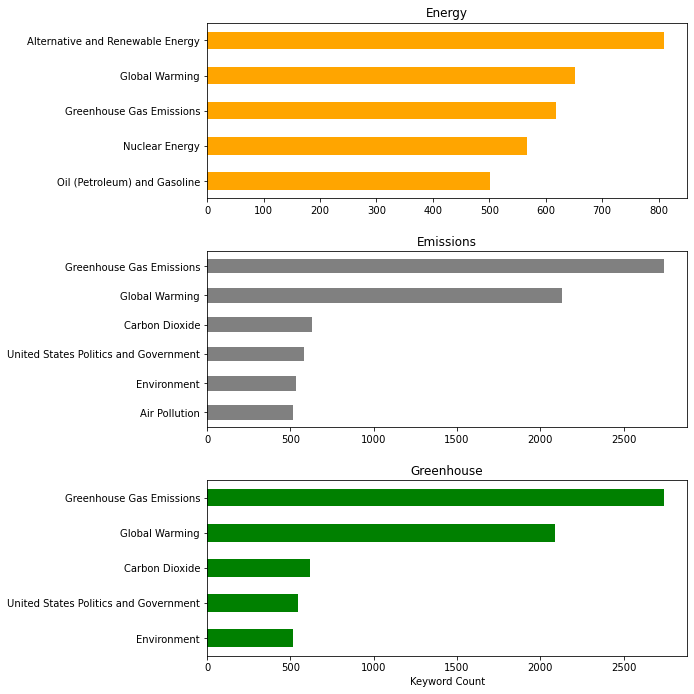

In [206]:
fig, ax = plt.subplots(3, 1, figsize = (10, 10))

to_1D(df_news_energy['keywords_code']).value_counts(ascending=True).loc[to_1D(df_news_energy['keywords_code']).value_counts() > 500].plot(kind='barh', color='orange', ax=ax[0])
to_1D(df_news_emissions['keywords_code']).value_counts(ascending=True).loc[to_1D(df_news_emissions['keywords_code']).value_counts() > 500].plot(kind='barh', color='grey', ax=ax[1])
to_1D(df_news_greenhouse['keywords_code']).value_counts(ascending=True).loc[to_1D(df_news_greenhouse['keywords_code']).value_counts() > 500].plot(kind='barh', color='green', ax=ax[2])

ax[0].set(title='Energy')
ax[1].set(title='Emissions')
ax[2].set(title='Greenhouse', xlabel='Keyword Count');

fig.tight_layout(pad = 2)



See a lot of overlap in articles that have 'energy', 'emission', and 'greenhouse' in their text. Tends to be a high count that contain the keyword 'Global Warming'. If I only look at articles that contain each of the aformentioned words in their text, I do not necessarily get solely Global Warming related articles. Just filtering articles by these words gives me less articles than by filtering by the 'Global Warming' keyword. 

In [209]:
df_news_greenhouse = df_news[df_news['keywords'].str.contains('Greenhouse Gas Emissions')]
df_news_greenhouse.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2744 entries, 124 to 687130
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   headline           2744 non-null   object
 1   date               2744 non-null   object
 2   doc_type           2744 non-null   object
 3   material_type      2744 non-null   object
 4   keywords           2744 non-null   object
 5   abstract           2744 non-null   object
 6   lead_paragraph     2741 non-null   object
 7   keywords_code      2744 non-null   object
 8   headline_abstract  2744 non-null   object
 9   text               2744 non-null   object
dtypes: object(10)
memory usage: 235.8+ KB


Since 'Greenhouse Gas Emissions' was a top keyword for the frequent words found in my topic model, I wanted to see if that may give me more article access than just 'Global Warming'. Global Warming related articles give me 4,000+ articles vs greenhouse gas related articles only give me 2744. This is confirmation that I will stick with 'Global Warming' keyword for the articles in my model if another modelling method does not work better.

### 2.0 iShares Global Clean Energy ETF data from Alpha Vantage API

I have the NYT article data per day per month for the last 10 years. I am requesting daily values for my ETF of interest.

#### 2.1 Data request and cleaning

In [210]:
import requests

In [211]:
base_url = 'https://www.alphavantage.co/query'

req = requests.get(
    base_url,
    params={
        "function": "TIME_SERIES_DAILY",
        "symbol": "ICLN",
        "outputsize": "full",
        "apikey": "LW9XCI6UYMQY5E14"
    }
)

req

<Response [200]>

In [212]:
data = req.json()
data['Time Series (Daily)']

{'2022-04-14': {'1. open': '21.0700',
  '2. high': '21.1550',
  '3. low': '20.7700',
  '4. close': '20.7800',
  '5. volume': '5552903'},
 '2022-04-13': {'1. open': '20.7900',
  '2. high': '21.0400',
  '3. low': '20.6100',
  '4. close': '21.0300',
  '5. volume': '4185624'},
 '2022-04-12': {'1. open': '21.1200',
  '2. high': '21.1600',
  '3. low': '20.7550',
  '4. close': '20.7700',
  '5. volume': '6745864'},
 '2022-04-11': {'1. open': '21.1200',
  '2. high': '21.2350',
  '3. low': '20.8800',
  '4. close': '21.0100',
  '5. volume': '7478823'},
 '2022-04-08': {'1. open': '21.5800',
  '2. high': '21.5800',
  '3. low': '21.2200',
  '4. close': '21.2300',
  '5. volume': '3457758'},
 '2022-04-07': {'1. open': '21.5900',
  '2. high': '21.8200',
  '3. low': '21.2600',
  '4. close': '21.5000',
  '5. volume': '5525993'},
 '2022-04-06': {'1. open': '21.8000',
  '2. high': '21.9200',
  '3. low': '21.4800',
  '4. close': '21.7600',
  '5. volume': '6389603'},
 '2022-04-05': {'1. open': '22.5700',
  '

In [213]:
data['Meta Data']

{'1. Information': 'Daily Prices (open, high, low, close) and Volumes',
 '2. Symbol': 'ICLN',
 '3. Last Refreshed': '2022-04-14',
 '4. Output Size': 'Full size',
 '5. Time Zone': 'US/Eastern'}

In [214]:
data_etf = pd.DataFrame(data['Time Series (Daily)']).T
data_etf

,1. open,2. high,3. low,4. close,5. volume
2022-04-14,21.0700,21.1550,20.7700,20.7800,5552903
2022-04-13,20.7900,21.0400,20.6100,21.0300,4185624
2022-04-12,21.1200,21.1600,20.7550,20.7700,6745864
2022-04-11,21.1200,21.2350,20.8800,21.0100,7478823
2022-04-08,21.5800,21.5800,21.2200,21.2300,3457758
...,...,...,...,...,...
2008-07-01,50.0000,50.0000,48.0600,48.8000,14900
2008-06-30,50.7700,50.9600,50.2500,50.2500,17100
2008-06-27,50.7900,50.7900,50.0900,50.1600,7700
2008-06-26,59.9900,59.9999,50.9900,51.0600,9800


In [354]:
# Get date range that I want 

data_etf = data_etf.loc['2022-04-08' : '2012-05-01']
data_etf

,1. open,2. high,3. low,4. close,5. volume
2022-04-08,21.5800,21.5800,21.2200,21.2300,3457758
2022-04-07,21.5900,21.8200,21.2600,21.5000,5525993
2022-04-06,21.8000,21.9200,21.4800,21.7600,6389603
2022-04-05,22.5700,22.7100,21.9450,22.0200,7144712
2022-04-04,21.6800,22.1500,21.6700,22.0800,4415980
...,...,...,...,...,...
2012-05-07,8.2500,8.2500,8.1200,8.1940,14500
2012-05-04,8.2500,8.3300,8.2100,8.2600,50700
2012-05-03,8.4700,8.4700,8.2650,8.2900,21000
2012-05-02,8.4600,8.5300,8.4300,8.5000,18000


In [303]:
# No nulls! 
data_etf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2507 entries, 2022-04-14 to 2012-05-01
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   1. open    2507 non-null   object
 1   2. high    2507 non-null   object
 2   3. low     2507 non-null   object
 3   4. close   2507 non-null   object
 4   5. volume  2507 non-null   object
dtypes: object(5)
memory usage: 117.5+ KB


In [304]:
# No duplicates! 
data_etf.duplicated().value_counts()

False    2507
dtype: int64

In [305]:
df_gw_sorted = df_news_gw.sort_values(by='date', ascending=False)
df_gw_sorted

#End date = 2022-04-16 
#Start date = 2012-05-01

,headline,date,doc_type,material_type,keywords,abstract,lead_paragraph,keywords_code,headline_abstract,text
38991,The Battery That Flies,2022-04-16,article,News,"['AIRLINES AND AIRPLANES', 'Batteries', 'Freig...",A new aircraft being built in Vermont has no n...,Kitty Hawk. The invention of the jet engine. A...,"[AIRLINES AND AIRPLANES, Batteries, Freight (C...",The Battery That Flies A new aircraft being bu...,the battery that flies a new aircraft being bu...
38940,Biden Plans to Open More Public Land to Drilling,2022-04-15,article,News,"['Federal Lands', 'Oil (Petroleum) and Gasolin...",The president is under pressure to bring down ...,WASHINGTON — The Biden administration announce...,"[Federal Lands, Oil (Petroleum) and Gasoline, ...",Biden Plans to Open More Public Land to Drilli...,biden plans to open more public land to drilli...
38899,Brazil’s climate politics are shifting. That m...,2022-04-15,article,News,"['Elections', 'Beef', 'Agriculture and Farming...",The Amazon is emerging as a central issue in t...,"In Brazil, beef isn’t just food. It’s politica...","[Elections, Beef, Agriculture and Farming, Ind...",Brazil’s climate politics are shifting. That m...,brazil’s climate politics are shifting that ma...
38898,"How Panera Bread Navigated Covid, the Labor Ma...",2022-04-15,article,News,"['Fast Food Industry', 'Executives and Managem...",Niren Chaudhary took over as C.E.O. just befor...,While Panera Bread is often situated in strip ...,"[Fast Food Industry, Executives and Management...","How Panera Bread Navigated Covid, the Labor Ma...",how panera bread navigated covid the labor mar...
38781,"Gina McCarthy, Top Climate Adviser, Is Said to...",2022-04-14,article,News,"['Global Warming', 'Greenhouse Gas Emissions',...",Ms. McCarthy was tapped by President Biden to ...,"WASHINGTON — Gina McCarthy, the White House cl...","[Global Warming, Greenhouse Gas Emissions, Uni...","Gina McCarthy, Top Climate Adviser, Is Said to...",gina mccarthy top climate adviser is said to b...
...,...,...,...,...,...,...,...,...,...,...
482062,Lights Out for Research Satellites?,2012-05-02,article,News,"['Earth', 'Earthquakes', 'Federal Budget (US)'...",Experts warn that the nation’s capability to c...,Earth-observing systems operated by the United...,"[Earth, Earthquakes, Federal Budget (US), Glob...",Lights Out for Research Satellites? Experts wa...,lights out for research satellites experts war...
481531,Clouds’ Effect on Climate Change Is Last Basti...,2012-05-01,article,News,"['Series', 'Global Warming', 'Carbon Dioxide',...","In recent years, climate change skeptics have ...","LAMONT, Okla. — For decades, a small group of ...","[Series, Global Warming, Carbon Dioxide, Green...",Clouds’ Effect on Climate Change Is Last Basti...,clouds’ effect on climate change is last basti...
481693,A Grim Portrait of Palm Oil Emissions,2012-05-01,article,News,"['Carbon Dioxide', 'Forests and Forestry', 'Gl...","A new study suggests that, if anything, a rece...",Indonesia ranks right behind the United States...,"[Carbon Dioxide, Forests and Forestry, Global ...",A Grim Portrait of Palm Oil Emissions A new st...,a grim portrait of palm oil emissions a new st...
481643,Polar Bears’ Long-Distance Swimming Skills on ...,2012-05-01,article,News,"['Endangered and Extinct Species', 'Global War...",A study charts epic Arctic swims by polar bears.,An innovative use of radio collars has allowed...,"[Endangered and Extinct Species, Global Warmin...",Polar Bears’ Long-Distance Swimming Skills on ...,polar bears’ long-distance swimming skills on ...


In [270]:
# Set date as the index 

gw_date = df_gw_sorted.set_index(pd.DatetimeIndex(df_gw_sorted['date']))

gw_date


,headline,date,doc_type,material_type,keywords,abstract,lead_paragraph,keywords_code,headline_abstract,text
date,,,,,,,,,,
2022-04-16,The Battery That Flies,2022-04-16,article,News,"['AIRLINES AND AIRPLANES', 'Batteries', 'Freig...",A new aircraft being built in Vermont has no n...,Kitty Hawk. The invention of the jet engine. A...,"[AIRLINES AND AIRPLANES, Batteries, Freight (C...",The Battery That Flies A new aircraft being bu...,the battery that flies a new aircraft being bu...
2022-04-15,Biden Plans to Open More Public Land to Drilling,2022-04-15,article,News,"['Federal Lands', 'Oil (Petroleum) and Gasolin...",The president is under pressure to bring down ...,WASHINGTON — The Biden administration announce...,"[Federal Lands, Oil (Petroleum) and Gasoline, ...",Biden Plans to Open More Public Land to Drilli...,biden plans to open more public land to drilli...
2022-04-15,Brazil’s climate politics are shifting. That m...,2022-04-15,article,News,"['Elections', 'Beef', 'Agriculture and Farming...",The Amazon is emerging as a central issue in t...,"In Brazil, beef isn’t just food. It’s politica...","[Elections, Beef, Agriculture and Farming, Ind...",Brazil’s climate politics are shifting. That m...,brazil’s climate politics are shifting that ma...
2022-04-15,"How Panera Bread Navigated Covid, the Labor Ma...",2022-04-15,article,News,"['Fast Food Industry', 'Executives and Managem...",Niren Chaudhary took over as C.E.O. just befor...,While Panera Bread is often situated in strip ...,"[Fast Food Industry, Executives and Management...","How Panera Bread Navigated Covid, the Labor Ma...",how panera bread navigated covid the labor mar...
2022-04-14,"Gina McCarthy, Top Climate Adviser, Is Said to...",2022-04-14,article,News,"['Global Warming', 'Greenhouse Gas Emissions',...",Ms. McCarthy was tapped by President Biden to ...,"WASHINGTON — Gina McCarthy, the White House cl...","[Global Warming, Greenhouse Gas Emissions, Uni...","Gina McCarthy, Top Climate Adviser, Is Said to...",gina mccarthy top climate adviser is said to b...
...,...,...,...,...,...,...,...,...,...,...
2012-05-02,Lights Out for Research Satellites?,2012-05-02,article,News,"['Earth', 'Earthquakes', 'Federal Budget (US)'...",Experts warn that the nation’s capability to c...,Earth-observing systems operated by the United...,"[Earth, Earthquakes, Federal Budget (US), Glob...",Lights Out for Research Satellites? Experts wa...,lights out for research satellites experts war...
2012-05-01,Clouds’ Effect on Climate Change Is Last Basti...,2012-05-01,article,News,"['Series', 'Global Warming', 'Carbon Dioxide',...","In recent years, climate change skeptics have ...","LAMONT, Okla. — For decades, a small group of ...","[Series, Global Warming, Carbon Dioxide, Green...",Clouds’ Effect on Climate Change Is Last Basti...,clouds’ effect on climate change is last basti...
2012-05-01,A Grim Portrait of Palm Oil Emissions,2012-05-01,article,News,"['Carbon Dioxide', 'Forests and Forestry', 'Gl...","A new study suggests that, if anything, a rece...",Indonesia ranks right behind the United States...,"[Carbon Dioxide, Forests and Forestry, Global ...",A Grim Portrait of Palm Oil Emissions A new st...,a grim portrait of palm oil emissions a new st...


In [347]:
# Article date range needs to be the same as ETF 

gw_date_range = gw_date.loc['2012-05-01' : '2022-04-08']
gw_date_range

,headline,date,doc_type,material_type,keywords,abstract,lead_paragraph,keywords_code,headline_abstract,text
date,,,,,,,,,,
2022-04-08,The Electric Car Market Heats Up,2022-04-08,article,News,"['Electric and Hybrid Vehicles', 'Shortages', ...",Soaring fuel prices and climate change concern...,Secondhand cars listed for tens of thousands m...,"[Electric and Hybrid Vehicles, Shortages, Fuel...",The Electric Car Market Heats Up Soaring fuel ...,the electric car market heats up soaring fuel ...
2022-04-08,"A low-cost, low-tech climate solution that sav...",2022-04-08,article,News,"['Global Warming', 'Greenhouse Gas Emissions',...",Early warnings systems for extreme weather can...,How do you save lives in an era of cascading c...,"[Global Warming, Greenhouse Gas Emissions, int...","A low-cost, low-tech climate solution that sav...",a low-cost low-tech climate solution that save...
2022-04-08,"As Gas Prices Went Up, So Did the Hunt for Ele...",2022-04-08,article,News,"['Electric and Hybrid Vehicles', 'Automobile S...",Prices at the pump have apparently given some ...,Thinking about buying an electric car? You’re ...,"[Electric and Hybrid Vehicles, Automobile Serv...","As Gas Prices Went Up, So Did the Hunt for Ele...",as gas prices went up so did the hunt for elec...
2022-04-08,How Is War Affecting Your Grocery Bill?,2022-04-08,article,News,"['Supply Chain', 'War and Armed Conflicts', 'I...",Ukraine and the global supply chain.,The Daily strives to reveal a new idea in ever...,"[Supply Chain, War and Armed Conflicts, Intern...",How Is War Affecting Your Grocery Bill? Ukrain...,how is war affecting your grocery bill ukraine...
2022-04-07,Another Variable in the Winemaking Process: Cl...,2022-04-07,article,News,"['Wines', 'Grapes', 'Global Warming']","After two years of fires, the California winer...","BERKELEY, Calif. — If anyone doubts the jarrin...","[Wines, Grapes, Global Warming]",Another Variable in the Winemaking Process: Cl...,another variable in the winemaking process cli...
...,...,...,...,...,...,...,...,...,...,...
2012-05-02,Lights Out for Research Satellites?,2012-05-02,article,News,"['Earth', 'Earthquakes', 'Federal Budget (US)'...",Experts warn that the nation’s capability to c...,Earth-observing systems operated by the United...,"[Earth, Earthquakes, Federal Budget (US), Glob...",Lights Out for Research Satellites? Experts wa...,lights out for research satellites experts war...
2012-05-01,Clouds’ Effect on Climate Change Is Last Basti...,2012-05-01,article,News,"['Series', 'Global Warming', 'Carbon Dioxide',...","In recent years, climate change skeptics have ...","LAMONT, Okla. — For decades, a small group of ...","[Series, Global Warming, Carbon Dioxide, Green...",Clouds’ Effect on Climate Change Is Last Basti...,clouds’ effect on climate change is last basti...
2012-05-01,A Grim Portrait of Palm Oil Emissions,2012-05-01,article,News,"['Carbon Dioxide', 'Forests and Forestry', 'Gl...","A new study suggests that, if anything, a rece...",Indonesia ranks right behind the United States...,"[Carbon Dioxide, Forests and Forestry, Global ...",A Grim Portrait of Palm Oil Emissions A new st...,a grim portrait of palm oil emissions a new st...


In [348]:
# Turn article value counts into a dataframe 

gw_vc = pd.DataFrame(gw_date_range.index.value_counts())
gw_vc




,date
2021-11-03,16
2014-09-22,15
2021-11-02,13
2021-11-01,13
2015-11-30,10
...,...
2017-06-29,1
2017-07-03,1
2017-07-04,1
2017-07-05,1


In [349]:
modified_gw = gw_vc.reset_index()
modified_gw

,index,date
0,2021-11-03,16
1,2014-09-22,15
2,2021-11-02,13
3,2021-11-01,13
4,2015-11-30,10
...,...,...
2280,2017-06-29,1
2281,2017-07-03,1
2282,2017-07-04,1
2283,2017-07-05,1


In [350]:
modified_gw.rename(columns = {'date':'article_count'}, inplace=True)
                              

In [351]:
modified_gw.rename(columns = {'index':'date'}, inplace=True)
modified_gw

,date,article_count
0,2021-11-03,16
1,2014-09-22,15
2,2021-11-02,13
3,2021-11-01,13
4,2015-11-30,10
...,...,...
2280,2017-06-29,1
2281,2017-07-03,1
2282,2017-07-04,1
2283,2017-07-05,1


In [355]:
modified_etf = data_etf.reset_index()
modified_etf.rename(columns = {'index':'date'}, inplace=True)
modified_etf.head(10)

,date,1. open,2. high,3. low,4. close,5. volume
0,2022-04-08,21.5800,21.5800,21.2200,21.2300,3457758
1,2022-04-07,21.5900,21.8200,21.2600,21.5000,5525993
2,2022-04-06,21.8000,21.9200,21.4800,21.7600,6389603
3,2022-04-05,22.5700,22.7100,21.9450,22.0200,7144712
4,2022-04-04,21.6800,22.1500,21.6700,22.0800,4415980
5,2022-04-01,21.6800,21.8500,21.4650,21.6400,5641433
6,2022-03-31,21.4600,21.7450,21.4600,21.5200,4641040
7,2022-03-30,21.6300,21.7700,21.3400,21.3900,4184370
8,2022-03-29,21.1900,21.4600,21.0150,21.4400,4000912
9,2022-03-28,21.0100,21.2050,20.8050,21.1300,3066803


In [296]:
modified_etf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3477 entries, 0 to 3476
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       3477 non-null   object
 1   1. open    3477 non-null   object
 2   2. high    3477 non-null   object
 3   3. low     3477 non-null   object
 4   4. close   3477 non-null   object
 5   5. volume  3477 non-null   object
dtypes: object(6)
memory usage: 163.1+ KB


In [356]:
# Make 'date' in ETF datetime 

modified_etf['date'] = pd.to_datetime(modified_etf['date'])
modified_etf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2503 entries, 0 to 2502
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       2503 non-null   datetime64[ns]
 1   1. open    2503 non-null   object        
 2   2. high    2503 non-null   object        
 3   3. low     2503 non-null   object        
 4   4. close   2503 non-null   object        
 5   5. volume  2503 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 117.5+ KB


#### 2.2 Merge NYT and ETF data

In [357]:
etf_gw = pd.merge(modified_etf, modified_gw, on="date", how="left")
etf_gw

,date,1. open,2. high,3. low,4. close,5. volume,article_count
0,2022-04-08,21.5800,21.5800,21.2200,21.2300,3457758,4.0
1,2022-04-07,21.5900,21.8200,21.2600,21.5000,5525993,4.0
2,2022-04-06,21.8000,21.9200,21.4800,21.7600,6389603,1.0
3,2022-04-05,22.5700,22.7100,21.9450,22.0200,7144712,2.0
4,2022-04-04,21.6800,22.1500,21.6700,22.0800,4415980,2.0
...,...,...,...,...,...,...,...
2498,2012-05-07,8.2500,8.2500,8.1200,8.1940,14500,NaN
2499,2012-05-04,8.2500,8.3300,8.2100,8.2600,50700,3.0
2500,2012-05-03,8.4700,8.4700,8.2650,8.2900,21000,5.0
2501,2012-05-02,8.4600,8.5300,8.4300,8.5000,18000,1.0


In [358]:
#Make all NaN values zero 

# df['DataFrame Column'] = df['DataFrame Column'].fillna(0)

etf_gw['article_count'] = etf_gw['article_count'].fillna(0)
etf_gw

,date,1. open,2. high,3. low,4. close,5. volume,article_count
0,2022-04-08,21.5800,21.5800,21.2200,21.2300,3457758,4.0
1,2022-04-07,21.5900,21.8200,21.2600,21.5000,5525993,4.0
2,2022-04-06,21.8000,21.9200,21.4800,21.7600,6389603,1.0
3,2022-04-05,22.5700,22.7100,21.9450,22.0200,7144712,2.0
4,2022-04-04,21.6800,22.1500,21.6700,22.0800,4415980,2.0
...,...,...,...,...,...,...,...
2498,2012-05-07,8.2500,8.2500,8.1200,8.1940,14500,0.0
2499,2012-05-04,8.2500,8.3300,8.2100,8.2600,50700,3.0
2500,2012-05-03,8.4700,8.4700,8.2650,8.2900,21000,5.0
2501,2012-05-02,8.4600,8.5300,8.4300,8.5000,18000,1.0


### 3.0 Building SARIMAX Model

Since I am using article count data as an exogenous variable, I am using SARIMAX for my volume forecasting model.

#### 3.1 Closer look at ETF Volume

In [359]:
# First need to set date as the index 

etf_gw.set_index('date', inplace = True)

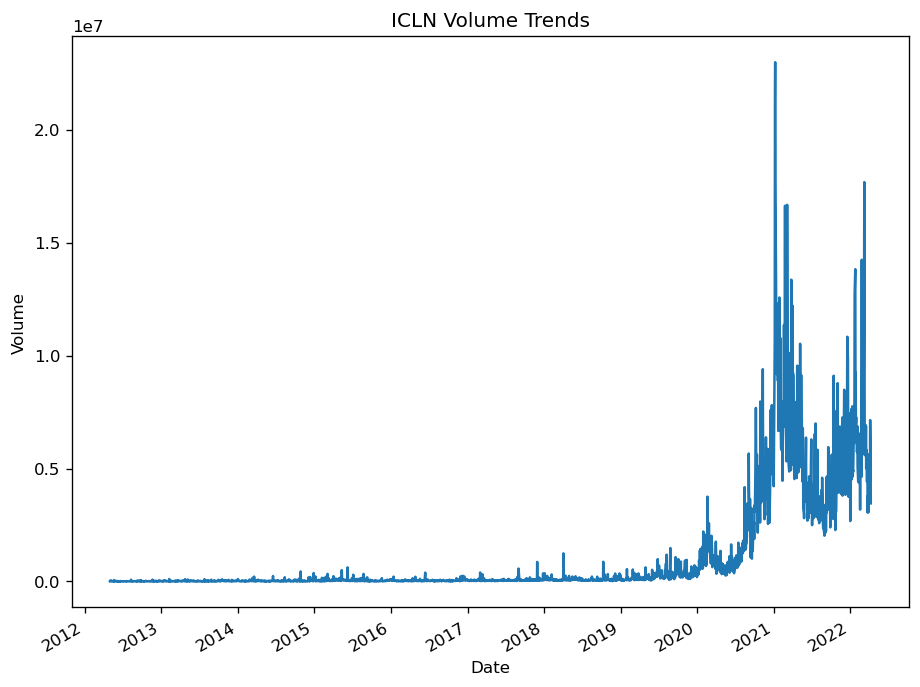

In [360]:
# Make volume column numeric 
etf_gw['volume'] = pd.to_numeric(etf_gw['5. volume']) 

# Take a look at the trends 

etf_gw['volume'].plot(title='ICLN Volume Trends', xlabel='Date', ylabel='Volume'); 


Volume has exploded in the last couple of years. Similar to the rise in frequency of global warming related articles. 

The non-stationary data means differencing may be necessary. 

Running an  Augmented Dickey Fuller (ADF) test:

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

In [361]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(etf_gw.volume)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.835976
p-value: 0.053316


Since p > 0.05 just barely - going to look at the order for differencing

In [318]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

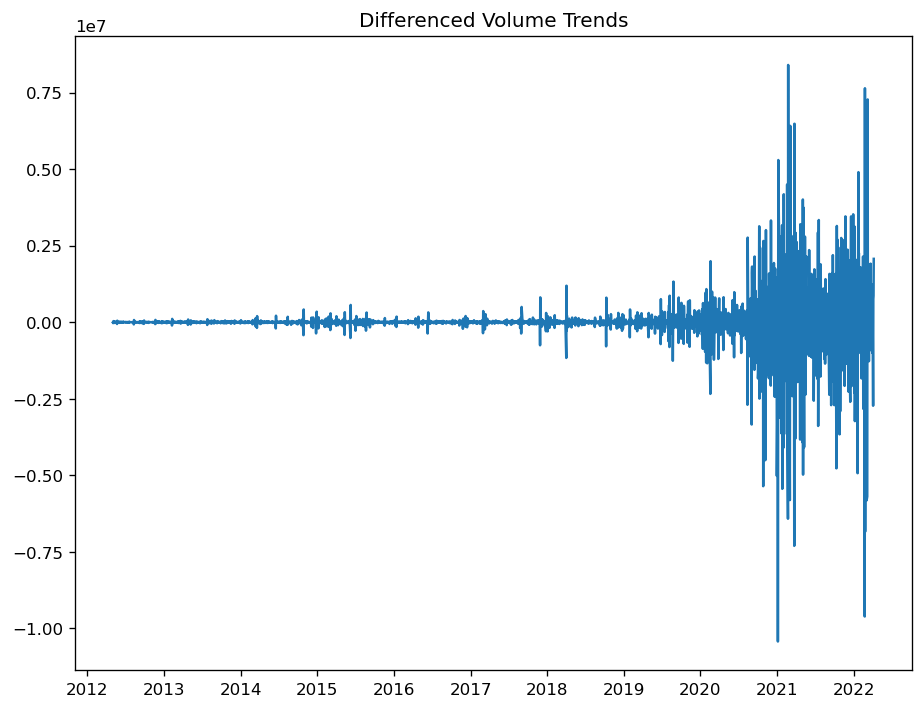

In [362]:
plt.plot(etf_gw.volume.diff())
plt.title('Differenced Volume Trends');

Take a look at different differencing parameters

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


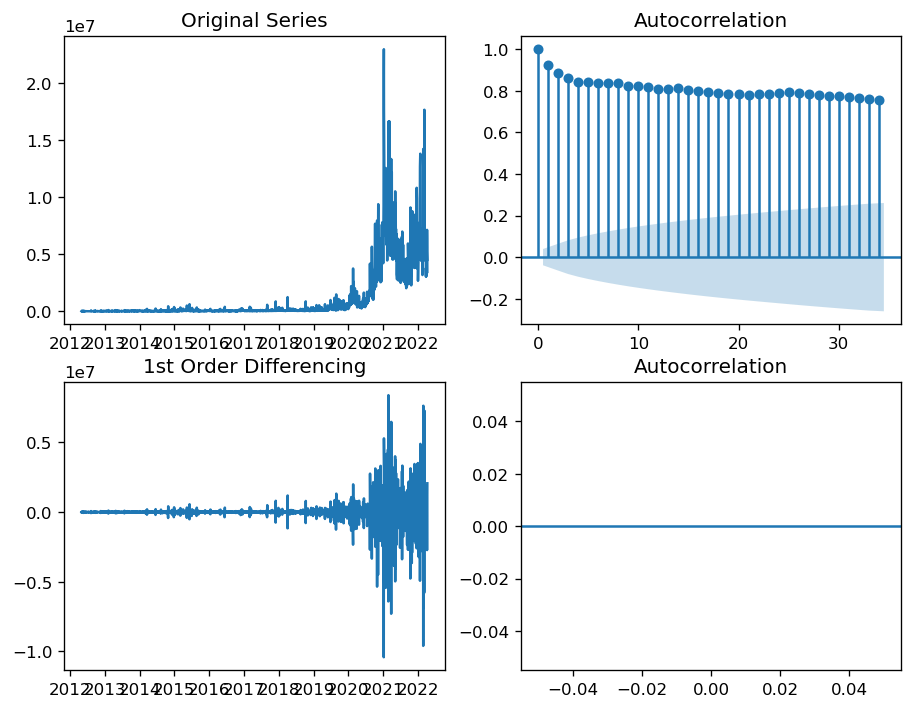

In [630]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(2, 2, sharex=False)
axes[0, 0].plot(etf_gw.volume); axes[0, 0].set_title('Original Series')
plot_acf(etf_gw.volume, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(etf_gw.volume.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(etf_gw.volume.diff(), ax=axes[1, 1])

plt.show()




Not absolutely certain if the autocorrelation for the 1st differencing is bad or not will determine based on AIC values.

#### 3.2 Training and Testing the Model

In [337]:
from sklearn.model_selection import train_test_split
import pmdarima as pm

In [364]:
# Train test split - do not shuffle the data since date order are important

X_train, X_test = train_test_split(etf_gw, shuffle = False)

SARIMAX 

- differencing = 0

In [365]:
model0 = pm.auto_arima(X_train[['volume']], exogenous=X_train[['article_count']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=None, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

model0.summary()

/opt/anaconda3/lib/python3.9/site-packages/pmdarima/compat/pmdarima.py:17: DeprecationWarning: The `exogenous` key-word has been deprecated. Please use `X` instead. This will raise an error in future versions. For more information, see: http://alkaline-ml.com/pmdarima/develop/rfc/372-exog-to-x.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=58297.146, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=73122.146, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=58607.156, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=59963.837, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=58228.977, Time=0.87 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=58416.353, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=58219.717, Time=1.33 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=58370.605, Time=0.40 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=58225.827, Time=1.93 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=58216.381, Time=1.74 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=58247.117, Time=0.65 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=58215.524, Time=1.29 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=58220.231, Time=0.81 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=58218.274, Time=1.25 sec
 ARIMA(2,0,3)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1877
Model:               SARIMAX(2, 0, 3)   Log Likelihood              -29100.762
Date:                Mon, 18 Apr 2022   AIC                          58215.524
Time:                        23:08:02   BIC                          58254.286
Sample:                             0   HQIC                         58229.802
                               - 1877                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
article_count  6.063e+05   1.25e+04     48.633      0.000    5.82e+05    6.31e+05
ar.L1             1.3872      0.083     16.675      0.000       1.224       1.550
ar.L2            -0.3897      0.083     -4.713      0.000      -0.552      -0.228
ma.L1            -0.9598      0.084    -11.393      0.000      -1.125      -0.795
ma.L2             0.1270      0.048      2.621      0.009       0.032       0.222
ma.L3            -0.0698      0.026     -2.703      0.007      -0.120      -0.019
sigma2         1.744e+12      0.002   8.93e+14      0.000    1.74e+12    1.74e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              4456.71
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                             0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.93e+29. Standard errors may be unstable.
"""

- differencing = 1

In [640]:
model1 = pm.auto_arima(X_train[['volume']], exogenous=X_train[['article_count']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=False,
                           d=1, D=None, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

model1.summary()

/opt/anaconda3/lib/python3.9/site-packages/pmdarima/compat/pmdarima.py:17: DeprecationWarning: The `exogenous` key-word has been deprecated. Please use `X` instead. This will raise an error in future versions. For more information, see: http://alkaline-ml.com/pmdarima/develop/rfc/372-exog-to-x.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=57071.146, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=57412.008, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=57283.408, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=57225.000, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=69674.232, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=57071.351, Time=0.72 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=57068.391, Time=1.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=57131.997, Time=0.45 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=57066.419, Time=1.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=57066.531, Time=1.30 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=57062.292, Time=1.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=57061.732, Time=0.84 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=57082.127, Time=0.51 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=57056.941, Time=0.72 sec
 ARIMA(0,1,3)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1877
Model:               SARIMAX(3, 1, 3)   Log Likelihood              -28505.438
Date:                Wed, 20 Apr 2022   AIC                          57026.875
Time:                        15:28:43   BIC                          57071.170
Sample:                             0   HQIC                         57043.192
                               - 1877                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
article_count  3.961e+04   1.35e+04      2.937      0.003    1.32e+04     6.6e+04
ar.L1            -0.5559      0.017    -32.687      0.000      -0.589      -0.523
ar.L2            -0.2939      0.017    -17.811      0.000      -0.326      -0.262
ar.L3             0.5185      0.012     44.412      0.000       0.496       0.541
ma.L1             0.1454      0.014     10.071      0.000       0.117       0.174
ma.L2            -0.0657      0.014     -4.733      0.000      -0.093      -0.038
ma.L3            -0.8446      0.011    -80.404      0.000      -0.865      -0.824
sigma2         9.464e+11      0.003      3e+14      0.000    9.46e+11    9.46e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):             35151.78
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             1.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.68e+29. Standard errors may be unstable.
"""

Appears that article count has a strong correlation with ETF volume trends! When differencing = 1, the AIC is lower so am going to use this model for predicting on the test data.

In [367]:
model1.predict(len(X_test.volume), X=X_test[['article_count']])

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:380: DeprecationWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  warnings.warn('No supported index is available. In the next'


array([ 59075.23784185, -25263.4569017 ,  18525.32731927, 157772.89998846,
       -15898.61528167, -11266.00165755,  40832.27595089,  64240.99702769,
        -7241.5969022 ,  39304.37811681, -14835.36722341,  -4785.60326458,
        76714.7050065 ,  25349.70487051,  76034.3640614 ,  34905.80446873,
        26399.97480425,  -2293.22188173,  -6648.89754732,  67373.25475418,
       116812.79898743,  71008.17960355,  68867.60215824, 393853.96858119,
       584814.08600835, 149553.29918009, 115981.59041916,  69207.79235509,
        71647.56628535,  35917.83069644, -10280.45502386,  33116.29121292,
        34959.56972314,  69015.77686796,  33914.70120219,  -5613.4560371 ,
        -9863.65806502,  -5187.32849303,  -6495.17456735,  -9346.33773184,
        74267.36782581,  32374.92176878,  70483.85880915,  -4952.48699112,
        -7797.92065695,  -8106.48162084,  34472.94009087,  -8172.27258375,
        -7517.81083984,  -5449.79171712,  31244.39819708,  -7013.23395888,
        -5835.68544324,  

/opt/anaconda3/lib/python3.9/site-packages/pmdarima/compat/pmdarima.py:17: DeprecationWarning: The `exogenous` key-word has been deprecated. Please use `X` instead. This will raise an error in future versions. For more information, see: http://alkaline-ml.com/pmdarima/develop/rfc/372-exog-to-x.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:380: DeprecationWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  warnings.warn('No supported index is available. In the next'


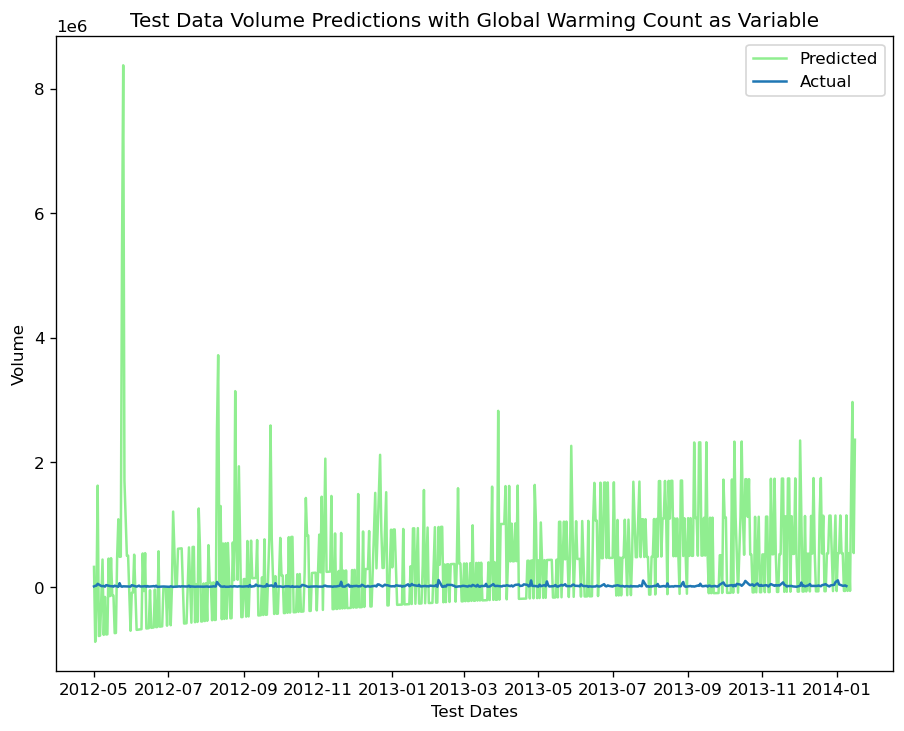

In [642]:
fitted, confint = model0.predict(n_periods=len(X_test.volume), 
                                  exogenous=np.tile(X_test[['article_count']], 1).reshape(-1,1), 
                                  return_conf_int=True)

index_of_fc = pd.date_range(X_test.index[-1], periods = len(X_test.volume), freq='D')
fitted_series = pd.Series(fitted, index=index_of_fc)
plt.plot(fitted_series, color='lightgreen', label='Predicted')

plt.plot(X_test.index[200:], X_test.volume[200:], label='Actual')
plt.title('Test Data Volume Predictions with Global Warming Count as Variable')
plt.xlabel('Test Dates')
plt.ylabel('Volume')


plt.legend();


#### 3.3 Forecast!

In [379]:
# April 1 2022 - May 31 2023
# Need to make pseudodata for article counts - get monthly means from the last year 

end = datetime.date(2023, 5, 1)
start = datetime.date(2022, 5, 1)

print('End:', end)
print('Start:', start)




End: 2023-05-01
Start: 2022-05-01


In [386]:
# Make pseudodata from 2021-04-01
gw_21


,headline,date,doc_type,material_type,keywords,abstract,lead_paragraph,keywords_code,year,month,day
189050,Add ‘Climate Hazards’ to Your Home-Buyer’s Che...,2021-06-01,article,News,"['Real Estate and Housing (Residential)', 'Flo...",Maps and other data are now available to help ...,As global temperatures increase and sea levels...,"[Real Estate and Housing (Residential), Floods...",2021,6,1
189074,Western States Sizzle Under Triple-Digit Tempe...,2021-06-01,article,News,"['Weather', 'Global Warming']",Temperatures in parts of California could reac...,Dangerously hot conditions and triple-digit te...,"[Weather, Global Warming]",2021,6,1
189108,Biden Suspends Drilling Leases in Arctic Natio...,2021-06-01,article,News,"['Wilderness Areas', 'Oil (Petroleum) and Gaso...","The decision blocks, for now, oil and gas dril...",WASHINGTON — The Biden administration on Tuesd...,"[Wilderness Areas, Oil (Petroleum) and Gasolin...",2021,6,1
189167,Here Are America’s Top Methane Emitters. Some ...,2021-06-02,article,News,"['Global Warming', 'Greenhouse Gas Emissions',...",Oil and gas giants are selling off their most-...,As the world’s oil and gas giants face increas...,"[Global Warming, Greenhouse Gas Emissions, Met...",2021,6,2
189208,A 20-Foot Sea Wall? Miami Faces the Hard Choic...,2021-06-02,article,News,"['Coastal Areas', 'Hurricanes and Tropical Sto...",A proposal to construct barriers for storm sur...,To hear more audio stories from publications l...,"[Coastal Areas, Hurricanes and Tropical Storms...",2021,6,2
...,...,...,...,...,...,...,...,...,...,...,...
504493,What Does Social Spending Mean for American Po...,2021-10-29,article,News,"['United States International Relations', 'Uni...",“It’s about leading the world or letting the w...,"It started as a sprawling, once-in-a-generatio...","[United States International Relations, United...",2021,10,29
504529,A Major Persian Gulf Oil Producer Tries to Bur...,2021-10-30,article,News,"['Oil (Petroleum) and Gasoline', 'Greenhouse G...",Trying to attract investors and retain custome...,"He is the chief executive of a major polluter,...","[Oil (Petroleum) and Gasoline, Greenhouse Gas ...",2021,10,30
504575,The COP26 Climate Talks Are Opening. Here’s Wh...,2021-10-30,article,News,"['Global Warming', 'Greenhouse Gas Emissions',...","Some fundamental differences, including over m...",The future is on the line.,"[Global Warming, Greenhouse Gas Emissions, Uni...",2021,10,30
504623,G20 leaders send a symbolic message on a key c...,2021-10-31,article,News,"['Global Warming', 'United Nations Framework C...",Countries will “pursue efforts” to limit globa...,Leaders of the Group of 20 nations sent a symb...,"[Global Warming, United Nations Framework Conv...",2021,10,31


In [421]:
gw_20.month.value_counts().sum()

486

In [422]:
gw_21.month.value_counts().sum()

846

Between 2020 and 2021 global warming related articles increased by 74%. For my 2022-2023 data I'm going to increase the 2021 data by 74% again and predict ETF volume.

In [443]:
gw_21_vc = pd.DataFrame(gw_21.month.value_counts())
gw_21_vc

,month
11,121
9,97
10,90
7,85
8,83
6,67
4,60
5,59
12,52
3,49


In [444]:
gw_21_vc.reset_index(inplace = True)
gw_21_vc

,index,month
0,11,121
1,9,97
2,10,90
3,7,85
4,8,83
5,6,67
6,4,60
7,5,59
8,12,52
9,3,49


In [445]:
gw_21_vc.rename(columns={'month':'article_count', 'index':'month'}, inplace = True)
gw_21_vc

,month,article_count
0,11,121
1,9,97
2,10,90
3,7,85
4,8,83
5,6,67
6,4,60
7,5,59
8,12,52
9,3,49


In [446]:
gw_21_vc_sorted = gw_21_vc.sort_values(by='month', ascending=True)
gw_21_vc_sorted

,month,article_count
11,1,41
10,2,42
9,3,49
6,4,60
7,5,59
5,6,67
3,7,85
4,8,83
1,9,97
2,10,90


In [448]:
# Increase each article count by 74% 

gw_21_vc_sorted['article_count_pseudo'] = gw_21_vc_sorted['article_count'].apply(lambda x: x + (x*.74))


In [464]:
gw_21_vc_sorted.reset_index(inplace = True)

In [ ]:
gw_21_vc_sorted.reset_index(inplace = True)
gw_21_vc_sorted.drop('index', axis=1, inplace=True)
gw_21_vc_sorted

In [465]:
gw_21_vc_sorted.drop('index', axis=1, inplace=True)

In [466]:
gw_21_vc_sorted

,month,article_count,article_count_pseudo
0,1,41,71.34
1,2,42,73.08
2,3,49,85.26
3,4,60,104.40
4,5,59,102.66
5,6,67,116.58
6,7,85,147.90
7,8,83,144.42
8,9,97,168.78
9,10,90,156.60


In [561]:
from datetime import date

date_range = pd.DataFrame(pd.date_range(date(2022,1, 1), date(2023,1, 1), freq='M'))

date_range


,0
0,2022-01-31
1,2022-02-28
2,2022-03-31
3,2022-04-30
4,2022-05-31
5,2022-06-30
6,2022-07-31
7,2022-08-31
8,2022-09-30
9,2022-10-31


In [562]:
date_range.rename(columns={0: 'date'}, inplace=True)

In [563]:
# Merge my date and pseudo-article_count datasets 


gw_22 = date_range.join(gw_21_vc_sorted)
gw_22

,date,month,article_count,article_count_pseudo
0,2022-01-31,1,41,71.34
1,2022-02-28,2,42,73.08
2,2022-03-31,3,49,85.26
3,2022-04-30,4,60,104.40
4,2022-05-31,5,59,102.66
5,2022-06-30,6,67,116.58
6,2022-07-31,7,85,147.90
7,2022-08-31,8,83,144.42
8,2022-09-30,9,97,168.78
9,2022-10-31,10,90,156.60


In [564]:
gw_22.set_index('date', inplace=True)

In [565]:
gw_22

,month,article_count,article_count_pseudo
date,,,
2022-01-31,1,41,71.34
2022-02-28,2,42,73.08
2022-03-31,3,49,85.26
2022-04-30,4,60,104.40
2022-05-31,5,59,102.66
2022-06-30,6,67,116.58
2022-07-31,7,85,147.90
2022-08-31,8,83,144.42
2022-09-30,9,97,168.78


In [566]:
# Use model on my predicted data 

model1.predict(len(gw_22.article_count_pseudo), X=gw_22[['article_count_pseudo']])


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:380: DeprecationWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  warnings.warn('No supported index is available. In the next'


array([2805625.14208892, 2869427.44304603, 3356054.81869306,
       4134606.04660521, 4050452.88702586, 4606455.19587812,
       5859525.3958513 , 5705481.80122249, 6678115.95773899,
       6202603.55753481, 8324631.2731022 , 3579117.41571833])

/opt/anaconda3/lib/python3.9/site-packages/pmdarima/compat/pmdarima.py:17: DeprecationWarning: The `exogenous` key-word has been deprecated. Please use `X` instead. This will raise an error in future versions. For more information, see: http://alkaline-ml.com/pmdarima/develop/rfc/372-exog-to-x.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:380: DeprecationWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  warnings.warn('No supported index is available. In the next'


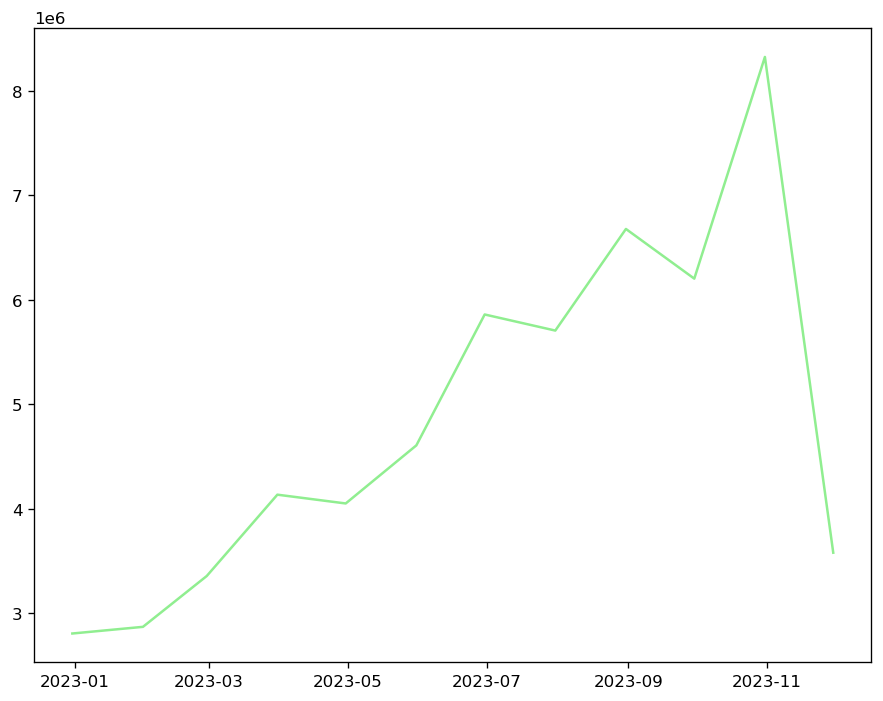

In [567]:
fitted, confint = model1.predict(n_periods=len(gw_22.article_count_pseudo), 
                                  exogenous=np.tile(gw_22[['article_count_pseudo']], 1).reshape(-1,1), 
                                  return_conf_int=True)

index_of_fc = pd.date_range(gw_22.index[-1], periods = len(gw_22.article_count_pseudo), freq='M')
fitted_series = pd.Series(fitted, index=index_of_fc)
plt.plot(fitted_series, color='lightgreen', label='Predicted')

#plt.plot(X_test.index[200:], X_test.volume[200:], label='Actual')
#plt.title('Test Data Volume Predictions with Global Warming Count as Variable')
#plt.xlabel('Test Dates')
#plt.ylabel('Volume')


#plt.legend();

In [ ]:
# df2.loc['2019-12-01':'2019-12-31']
# bike['month'] = bike['datetime'].dt.month

In [509]:
etf_gw_21 = etf_gw.loc['2021-04-01':'2022-03-31']
etf_gw_21

,1. open,2. high,3. low,4. close,5. volume,article_count,volume
date,,,,,,,
2021-12-31,21.2100,21.3975,21.1450,21.1700,2675619,0.0,2675619
2021-12-30,20.9800,21.3555,20.9500,21.2100,6198769,1.0,6198769
2021-12-29,20.9800,21.0701,20.7450,20.9300,5264288,2.0,5264288
2021-12-28,21.1300,21.2050,20.9400,21.0000,7438085,2.0,7438085
2021-12-27,21.2300,21.3250,21.0600,21.2100,5832640,1.0,5832640
...,...,...,...,...,...,...,...
2021-01-08,34.1460,34.2500,32.6300,33.1600,17693917,1.0,17693917
2021-01-07,32.9700,33.7900,32.6200,33.4100,22989382,2.0,22989382
2021-01-06,30.6100,32.1700,30.4201,31.4000,21173226,3.0,21173226


In [510]:
etf_gw_21.reset_index(inplace = True)

In [511]:
etf_gw_21.head(2)

,date,1. open,2. high,3. low,4. close,5. volume,article_count,volume
0,2021-12-31,21.2100,21.3975,21.1450,21.1700,2675619,0.0,2675619
1,2021-12-30,20.9800,21.3555,20.9500,21.2100,6198769,1.0,6198769


In [513]:
# 

etf_gw_21.reset_index(inplace = True)

avg_vol_21 = pd.DataFrame(etf_gw_21.groupby(pd.PeriodIndex(etf_gw_21['date'], freq='M'))['volume'].mean())

In [521]:
avg_vol_21.reset_index(inplace=True)

In [523]:
avg_vol_21.rename(columns = {'date':'2021', 'volume':'vol_21'}, inplace=True)

In [524]:
avg_vol_21

,2021,vol_21
0,2021-01,1.189547e+07
1,2021-02,8.116464e+06
2,2021-03,8.538194e+06
3,2021-04,6.410955e+06
4,2021-05,5.890140e+06
5,2021-06,3.989531e+06
6,2021-07,4.222399e+06
7,2021-08,3.053298e+06
8,2021-09,3.801979e+06
9,2021-10,4.765301e+06


In [552]:
# Reset on index 

new_gw = gw_22.reset_index()

In [553]:
new_gw

,date,month,article_count,article_count_pseudo
0,2020-01-31,1,41,71.34
1,2020-02-29,2,42,73.08
2,2020-03-31,3,49,85.26
3,2020-04-30,4,60,104.40
4,2020-05-31,5,59,102.66
5,2020-06-30,6,67,116.58
6,2020-07-31,7,85,147.90
7,2020-08-31,8,83,144.42
8,2020-09-30,9,97,168.78
9,2020-10-31,10,90,156.60


In [554]:
actual_vol_21 = new_gw.join(avg_vol_21)
actual_vol_21

,date,month,article_count,article_count_pseudo,vol_21
0,2020-01-31,1,41,71.34,1.189547e+07
1,2020-02-29,2,42,73.08,8.116464e+06
2,2020-03-31,3,49,85.26,8.538194e+06
3,2020-04-30,4,60,104.40,6.410955e+06
4,2020-05-31,5,59,102.66,5.890140e+06
5,2020-06-30,6,67,116.58,3.989531e+06
6,2020-07-31,7,85,147.90,4.222399e+06
7,2020-08-31,8,83,144.42,3.053298e+06
8,2020-09-30,9,97,168.78,3.801979e+06
9,2020-10-31,10,90,156.60,4.765301e+06


In [555]:
# Make date the index again 

actual_vol_21.set_index('date', inplace=True)

In [556]:
actual_vol_21

,month,article_count,article_count_pseudo,vol_21
date,,,,
2020-01-31,1,41,71.34,1.189547e+07
2020-02-29,2,42,73.08,8.116464e+06
2020-03-31,3,49,85.26,8.538194e+06
2020-04-30,4,60,104.40,6.410955e+06
2020-05-31,5,59,102.66,5.890140e+06
2020-06-30,6,67,116.58,3.989531e+06
2020-07-31,7,85,147.90,4.222399e+06
2020-08-31,8,83,144.42,3.053298e+06
2020-09-30,9,97,168.78,3.801979e+06


/opt/anaconda3/lib/python3.9/site-packages/pmdarima/compat/pmdarima.py:17: DeprecationWarning: The `exogenous` key-word has been deprecated. Please use `X` instead. This will raise an error in future versions. For more information, see: http://alkaline-ml.com/pmdarima/develop/rfc/372-exog-to-x.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:380: DeprecationWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  warnings.warn('No supported index is available. In the next'


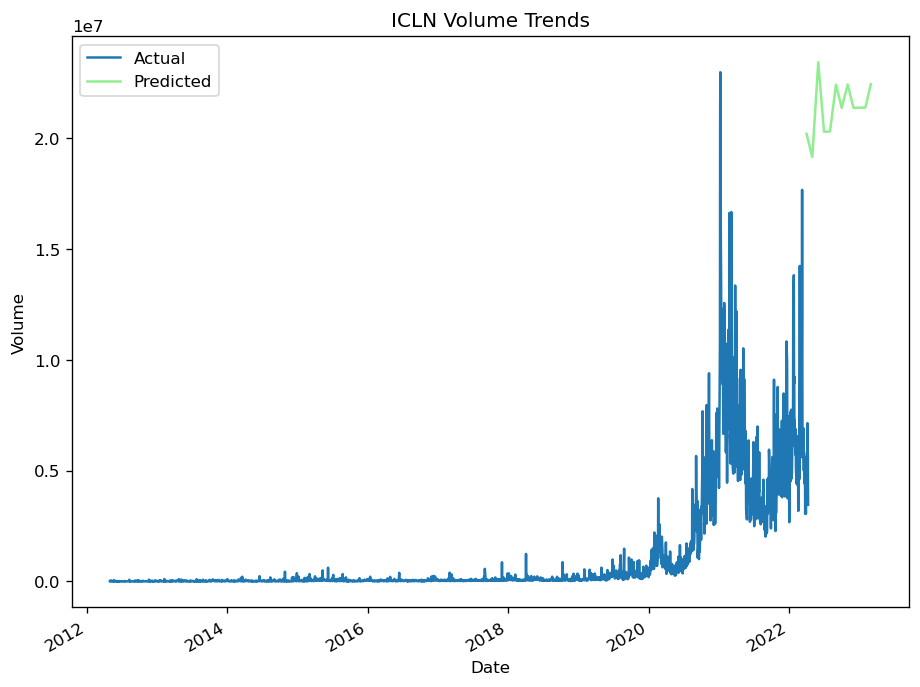

In [646]:
etf_gw['volume'].plot(title='ICLN Volume Trends', xlabel='Date', ylabel='Volume', label='Actual')

fitted, confint = model0.predict(n_periods=len(gw_22.article_count_pseudo), 
                                  exogenous=np.tile(gw_22[['article_count_pseudo']], 1).reshape(-1,1), 
                                  return_conf_int=True)

index_of_fc = pd.date_range(gw_22.index[-1], periods = len(gw_22.article_count_pseudo), freq='M')
fitted_series = pd.Series(fitted, index=index_of_fc)
plt.plot(fitted_series, color='lightgreen', label='Predicted')

plt.legend();




# Start over

In [573]:
#etf_gw_21 = etf_gw.loc['2021-01-01':'2021-12-31']
#etf_gw_21

etf_21 = etf_gw.loc['2021-04-01':'2022-03-31']
etf_21

,1. open,2. high,3. low,4. close,5. volume,article_count,volume
date,,,,,,,
2022-03-31,21.4600,21.7450,21.4600,21.5200,4641040,0.0,4641040
2022-03-30,21.6300,21.7700,21.3400,21.3900,4184370,1.0,4184370
2022-03-29,21.1900,21.4600,21.0150,21.4400,4000912,3.0,4000912
2022-03-28,21.0100,21.2050,20.8050,21.1300,3066803,0.0,3066803
2022-03-25,21.2800,21.2800,20.7150,21.0400,3794886,7.0,3794886
...,...,...,...,...,...,...,...
2021-04-09,23.2100,23.5000,23.1600,23.4700,4534463,2.0,4534463
2021-04-08,23.5200,23.6500,23.3500,23.4400,4851586,2.0,4851586
2021-04-07,23.8300,23.8300,23.0419,23.1400,5636503,2.0,5636503


In [578]:
etf_21.reset_index(inplace=True)

In [579]:
etf_21['month'] = etf_21['date'].dt.month

In [580]:
gw_21_vc = pd.DataFrame(etf_21.month.value_counts())
gw_21_vc

,month
3,23
12,22
8,22
6,22
11,21
10,21
9,21
7,21
1,20
5,20


In [581]:
gw_21_vc.reset_index(inplace = True)
gw_21_vc

,index,month
0,3,23
1,12,22
2,8,22
3,6,22
4,11,21
5,10,21
6,9,21
7,7,21
8,1,20
9,5,20


In [582]:
gw_21_vc.rename(columns={'month':'article_count', 'index':'month'}, inplace = True)
gw_21_vc

,month,article_count
0,3,23
1,12,22
2,8,22
3,6,22
4,11,21
5,10,21
6,9,21
7,7,21
8,1,20
9,5,20


In [583]:
gw_21_vc_sorted = gw_21_vc.sort_values(by='month', ascending=True)
gw_21_vc_sorted

,month,article_count
8,1,20
11,2,19
0,3,23
10,4,20
9,5,20
3,6,22
7,7,21
2,8,22
6,9,21
5,10,21


In [584]:
# Increase each article count by 74% 

gw_21_vc_sorted['article_count_pseudo'] = gw_21_vc_sorted['article_count'].apply(lambda x: x + (x*.74))


In [585]:
gw_21_vc_sorted.reset_index(inplace = True)
gw_21_vc_sorted.drop('index', axis=1, inplace=True)
gw_21_vc_sorted

,month,article_count,article_count_pseudo
0,1,20,34.80
1,2,19,33.06
2,3,23,40.02
3,4,20,34.80
4,5,20,34.80
5,6,22,38.28
6,7,21,36.54
7,8,22,38.28
8,9,21,36.54
9,10,21,36.54


In [586]:
from datetime import date

date_range = pd.DataFrame(pd.date_range(date(2021,4, 1), date(2022,3, 31), freq='M'))

date_range

,0
0,2021-04-30
1,2021-05-31
2,2021-06-30
3,2021-07-31
4,2021-08-31
5,2021-09-30
6,2021-10-31
7,2021-11-30
8,2021-12-31
9,2022-01-31


In [587]:
date_range.rename(columns={0: 'date'}, inplace=True)

gw_22 = date_range.join(gw_21_vc_sorted)
gw_22

,date,month,article_count,article_count_pseudo
0,2021-04-30,1,20,34.80
1,2021-05-31,2,19,33.06
2,2021-06-30,3,23,40.02
3,2021-07-31,4,20,34.80
4,2021-08-31,5,20,34.80
5,2021-09-30,6,22,38.28
6,2021-10-31,7,21,36.54
7,2021-11-30,8,22,38.28
8,2021-12-31,9,21,36.54
9,2022-01-31,10,21,36.54


In [601]:
gw_22.set_index('date', inplace = True)

/opt/anaconda3/lib/python3.9/site-packages/pmdarima/compat/pmdarima.py:17: DeprecationWarning: The `exogenous` key-word has been deprecated. Please use `X` instead. This will raise an error in future versions. For more information, see: http://alkaline-ml.com/pmdarima/develop/rfc/372-exog-to-x.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:380: DeprecationWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  warnings.warn('No supported index is available. In the next'


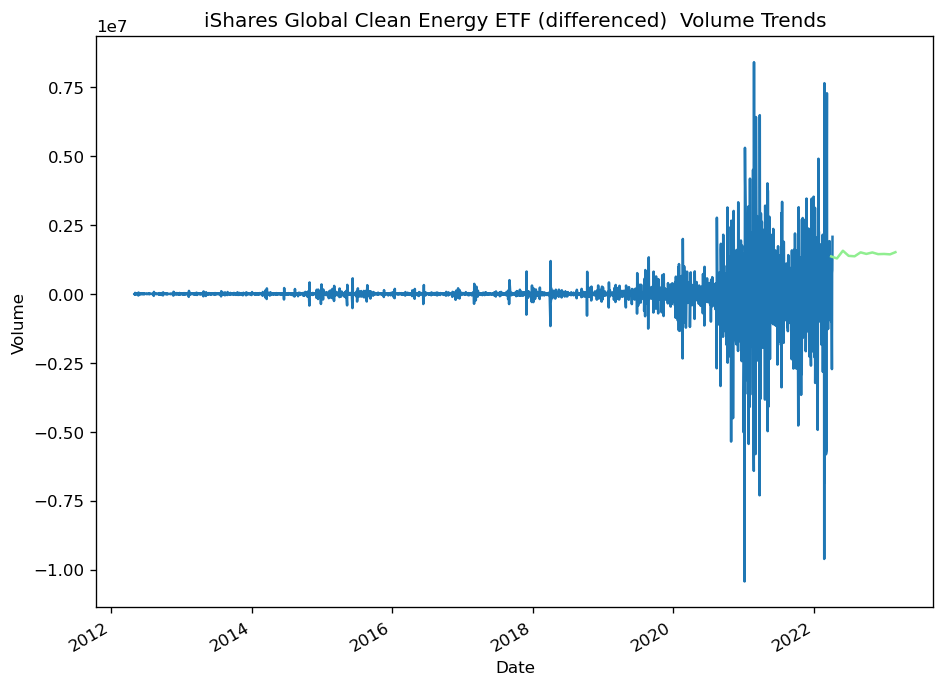

In [625]:
etf_gw['volume'].diff().plot(title='iShares Global Clean Energy ETF (differenced)  Volume Trends', xlabel='Date', ylabel='Volume')

fitted, confint = model1.predict(n_periods=len(gw_22.article_count_pseudo), 
                                  exogenous=np.tile(gw_22[['article_count_pseudo']], 1).reshape(-1,1), 
                                  return_conf_int=True)

index_of_fc = pd.date_range(gw_22.index[-1], periods = len(gw_22.article_count_pseudo), freq='M')
fitted_series = pd.Series(fitted, index=index_of_fc)
plt.plot(fitted_series, color='lightgreen', label='Predicted')


# Smoothing my time series instead 

I calculate the moving average by feature engineering a new column using panda’s built-in rolling method.

Choosing a window of seven days (weekly) 

In [693]:
etf_gw['mov_avg'] = etf_gw['volume'].rolling(7).sum()

In [694]:
etf_gw

,1. open,2. high,3. low,4. close,5. volume,article_count,volume,mov_avg
date,,,,,,,,
2022-04-08,21.5800,21.5800,21.2200,21.2300,3457758,4.0,3457758,NaN
2022-04-07,21.5900,21.8200,21.2600,21.5000,5525993,4.0,5525993,NaN
2022-04-06,21.8000,21.9200,21.4800,21.7600,6389603,1.0,6389603,NaN
2022-04-05,22.5700,22.7100,21.9450,22.0200,7144712,2.0,7144712,NaN
2022-04-04,21.6800,22.1500,21.6700,22.0800,4415980,2.0,4415980,NaN
...,...,...,...,...,...,...,...,...
2012-05-07,8.2500,8.2500,8.1200,8.1940,14500,0.0,14500,106700.0
2012-05-04,8.2500,8.3300,8.2100,8.2600,50700,3.0,50700,145400.0
2012-05-03,8.4700,8.4700,8.2650,8.2900,21000,5.0,21000,151400.0


<AxesSubplot:title={'center':'ICLN Volume Trends'}, xlabel='Date', ylabel='Volume Moving Average'>

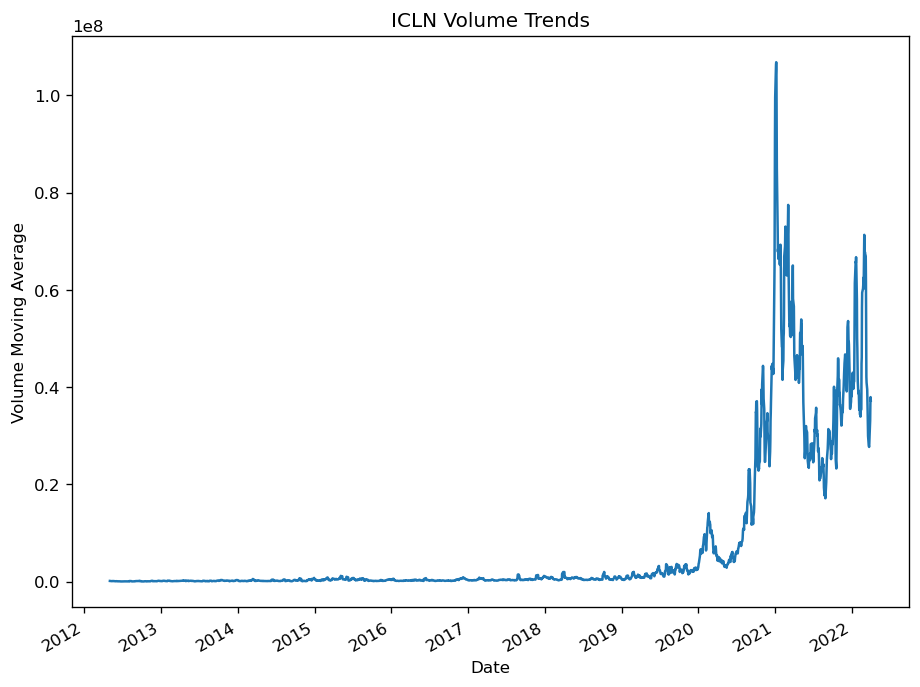

In [695]:
etf_gw['mov_avg'].plot(title='ICLN Volume Trends', xlabel='Date', ylabel='Volume Moving Average', label='Actual')

Trend looks so much smoother!!! 

In [697]:
etf_gw[etf_gw['mov_avg'].isnull()]

,1. open,2. high,3. low,4. close,5. volume,article_count,volume,mov_avg
date,,,,,,,,
2022-04-08,21.5800,21.5800,21.2200,21.2300,3457758,4.0,3457758,NaN
2022-04-07,21.5900,21.8200,21.2600,21.5000,5525993,4.0,5525993,NaN
2022-04-06,21.8000,21.9200,21.4800,21.7600,6389603,1.0,6389603,NaN
2022-04-05,22.5700,22.7100,21.9450,22.0200,7144712,2.0,7144712,NaN
2022-04-04,21.6800,22.1500,21.6700,22.0800,4415980,2.0,4415980,NaN
2022-04-01,21.6800,21.8500,21.4650,21.6400,5641433,6.0,5641433,NaN


In [698]:
new_etf = etf_gw.loc['2017-05-01':'2022-03-31']

In [699]:
new_etf

,1. open,2. high,3. low,4. close,5. volume,article_count,volume,mov_avg
date,,,,,,,,
2022-03-31,21.4600,21.7450,21.4600,21.5200,4641040,0.0,4641040,37216519.0
2022-03-30,21.6300,21.7700,21.3400,21.3900,4184370,1.0,4184370,37943131.0
2022-03-29,21.1900,21.4600,21.0150,21.4400,4000912,3.0,4000912,36418050.0
2022-03-28,21.0100,21.2050,20.8050,21.1300,3066803,0.0,3066803,33095250.0
2022-03-25,21.2800,21.2800,20.7150,21.0400,3794886,7.0,3794886,29745424.0
...,...,...,...,...,...,...,...,...
2017-05-08,8.6800,8.6900,8.5801,8.5900,46928,2.0,46928,245831.0
2017-05-05,8.6400,8.7400,8.6000,8.7400,35094,0.0,35094,230158.0
2017-05-04,8.6000,8.6100,8.5201,8.5850,27505,0.0,27505,234962.0


<AxesSubplot:title={'center':'ICLN Volume Trends'}, xlabel='Date', ylabel='Volume Moving Average'>

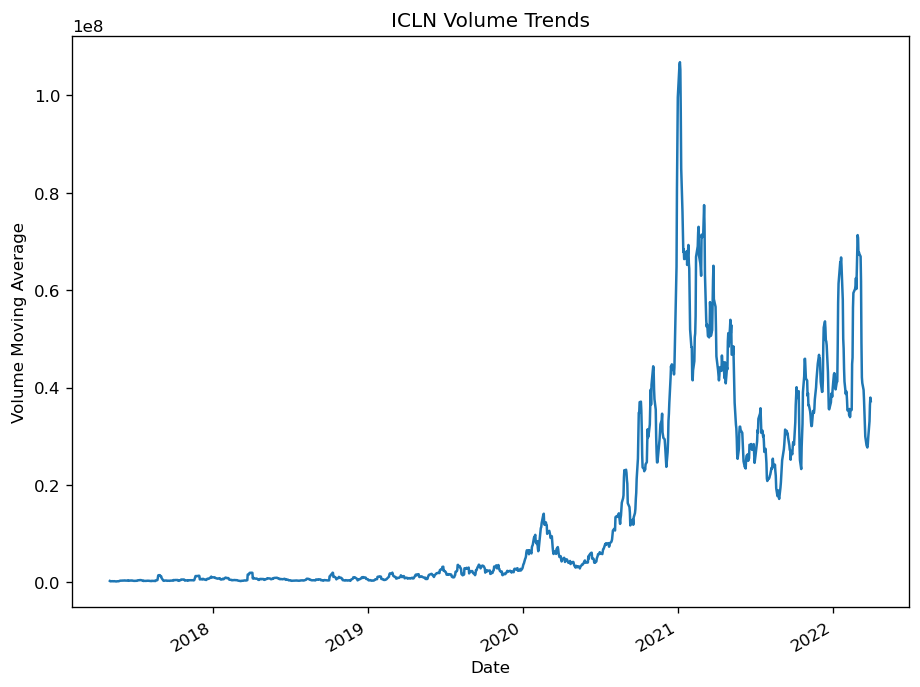

In [700]:
new_etf['mov_avg'].plot(title='ICLN Volume Trends', xlabel='Date', ylabel='Volume Moving Average', label='Actual')

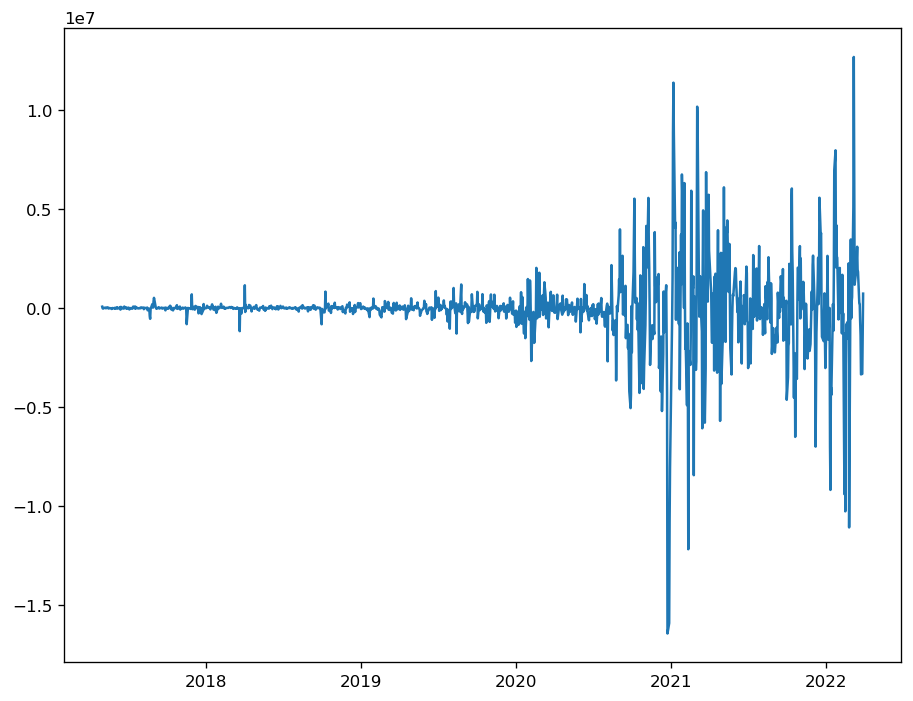

In [701]:
plt.plot(new_etf.mov_avg.diff())

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


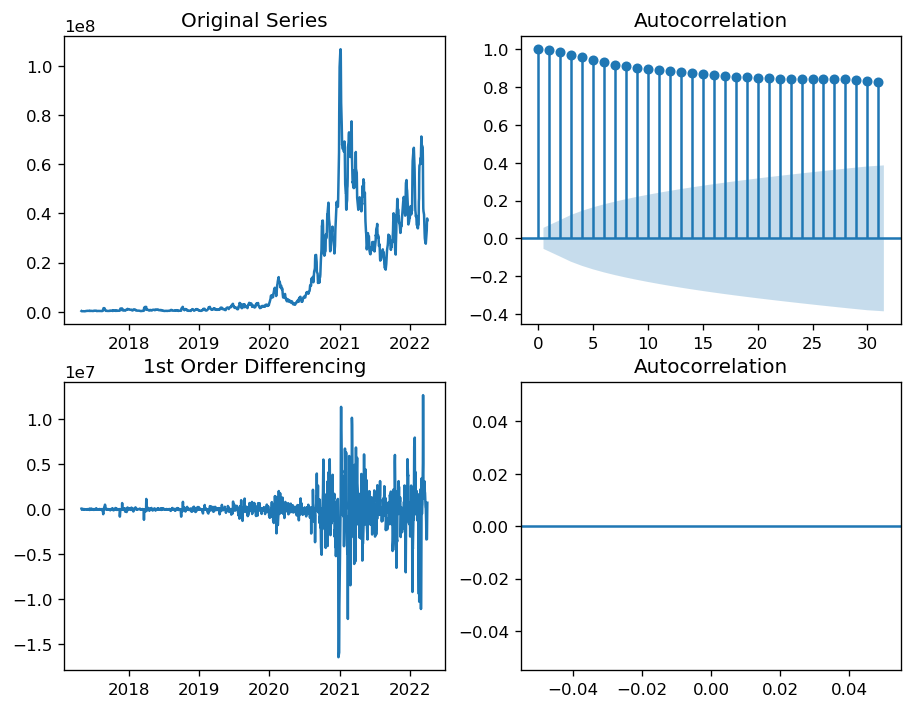

In [702]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(2, 2, sharex=False)
axes[0, 0].plot(new_etf.mov_avg); axes[0, 0].set_title('Original Series')
plot_acf(new_etf.mov_avg, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(new_etf.mov_avg.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(new_etf.mov_avg.diff(), ax=axes[1, 1])

plt.show()

In [703]:
X_train, X_test = train_test_split(new_etf, shuffle = False)

In [704]:
model = pm.auto_arima(X_train[['mov_avg']], exogenous=X_train[['article_count']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=False,
                           d=None, D=None, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

model.summary()

/opt/anaconda3/lib/python3.9/site-packages/pmdarima/compat/pmdarima.py:17: DeprecationWarning: The `exogenous` key-word has been deprecated. Please use `X` instead. This will raise an error in future versions. For more information, see: http://alkaline-ml.com/pmdarima/develop/rfc/372-exog-to-x.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=29526.020, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=29742.979, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=29526.237, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=29567.198, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=35155.336, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=29527.239, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=29524.615, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=29530.861, Time=0.24 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=29497.311, Time=0.93 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=29494.744, Time=0.98 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=29503.769, Time=0.73 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=29513.624, Time=2.07 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.50 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=29451.983, Time=1.36 sec
 ARIMA(2,1,2)(0,0,0)[0]  

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  929
Model:               SARIMAX(3, 1, 2)   Log Likelihood              -14718.992
Date:                Wed, 20 Apr 2022   AIC                          29451.983
Time:                        18:07:23   BIC                          29485.815
Sample:                             0   HQIC                         29464.888
                                - 929                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
article_count  4.244e+04    2.6e+04      1.635      0.102   -8424.915    9.33e+04
ar.L1             1.5428      0.012    126.611      0.000       1.519       1.567
ar.L2            -1.1914      0.023    -52.911      0.000      -1.236      -1.147
ar.L3             0.2620      0.014     19.062      0.000       0.235       0.289
ma.L1            -1.2713      0.009   -139.958      0.000      -1.289      -1.253
ma.L2             0.9657      0.010     96.007      0.000       0.946       0.985
sigma2          3.49e+12      0.002   2.22e+15      0.000    3.49e+12    3.49e+12
===================================================================================
Ljung-Box (L1) (Q):                  28.94   Jarque-Bera (JB):              3160.76
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.01   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.71e+29. Standard errors may be unstable.
"""

/opt/anaconda3/lib/python3.9/site-packages/pmdarima/compat/pmdarima.py:17: DeprecationWarning: The `exogenous` key-word has been deprecated. Please use `X` instead. This will raise an error in future versions. For more information, see: http://alkaline-ml.com/pmdarima/develop/rfc/372-exog-to-x.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:380: DeprecationWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  warnings.warn('No supported index is available. In the next'


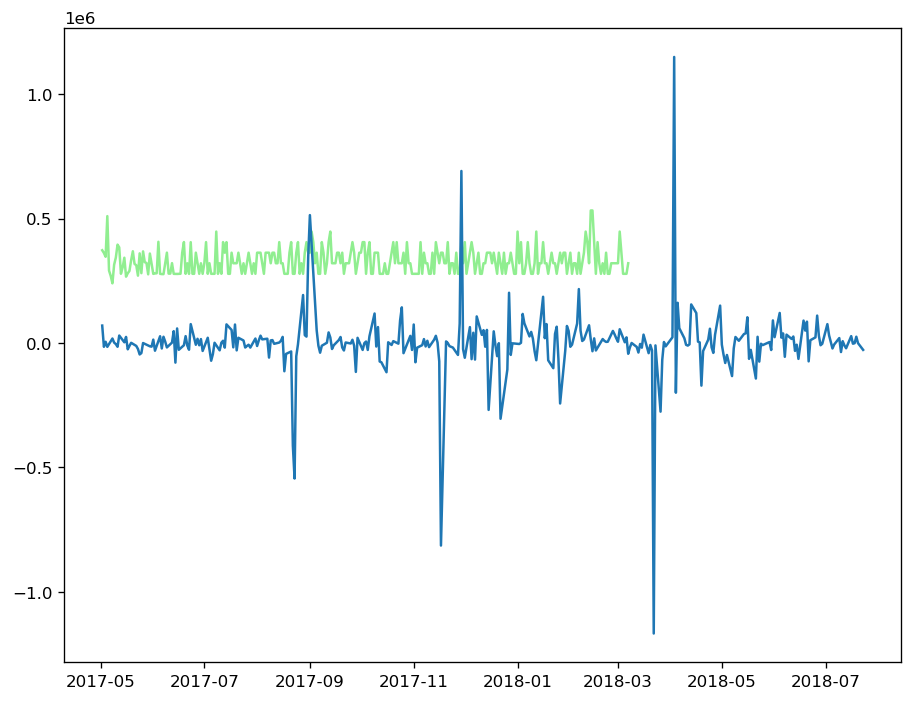

In [706]:
fitted, confint = model.predict(n_periods=len(X_test.mov_avg), 
                                  exogenous=np.tile(X_test[['article_count']], 1).reshape(-1,1), 
                                  return_conf_int=True)


index_of_fc = pd.date_range(X_test.index[-1], periods = len(X_test.volume), freq='D')
fitted_series = pd.Series(fitted, index=index_of_fc)
plt.plot(fitted_series, color='lightgreen')

plt.plot(X_test.index, X_test.mov_avg.diff())
